In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
from starlette.config import Config

import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto

from googletrans import Translator
import googlemaps

from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error
import xgboost as xgb
from hyperopt.pyll.base import scope 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import smogn

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)
# google_api_key = config("HASEKO_GOOGLE_API_KEY", cast=str)
# gmaps = googlemaps.Client(key=google_api_key)

%matplotlib inline

In [2]:
def get_boundaries(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, column):
    lower_bound, upper_bound = get_boundaries(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def reverse_transform(X, tr):
    for name, transfo in enumerate(list(tr[0])):
        if transfo =='Squared':
            X = np.squeeze(np.square(X))
        elif transfo == 'Log':
            X = np.squeeze(np.expm1(X))
        else:
            X = np.squeeze(X)
    return X

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

# New training data

In [3]:
area = {'1100': 'Saitama',
        '1200': 'Chiba',
        '1301': 'Central Tokyo',
        '1302': 'Western Tokyo',
        '1303': 'Eastern Tokyo',
        '1304': 'Tokyo city',
        '1400': 'Kanagawa'}

new_dict = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1','合算後年収\nAnnual income after the sum', '家族数\nFamily number',
            '家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)', '面積\narea','LP名\nLP name',
            '最新住所\nLatest address']

In [4]:
data_dir = '../../haseko_v1_data_analysis/data/コピーデータ240215_4回目.xls'
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]
df['物件価格(千円)\nProperty price (1,000 yen)'] /= 10

# Select relevant columns
df = df[new_dict]
# Remove outlier
df = remove_outliers(df, '面積\narea')
# Remove possible pair loan
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','最新住所\nLatest address']
dup = df[df.duplicated(subset=col, keep=False)]
df = df.loc[[i for i in df.index if i not in dup.index],:]

print(df.shape)
df.head()

(3740, 9)


年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
2       36                                        8   
3       48                                        4   
4       42                                        4   
5       29                                        4   
6       51                                        4   

  合算後年収\nAnnual income after the sum  家族数\nFamily number 家族F\nFamily F  \
2                             ～800万円                   2         DINKS   
3                             ～400万円                   1            独身   
4                             ～500万円                   1            独身   
5                             ～500万円                   3            独身   
6                             ～400万円                   1            独身   

   物件価格(千円)\nProperty price (1,000 yen)  面積\narea LP名\nLP name  \
2                                3298.0     35.73    今回追加したデータ   
3                                3378.0     35.73    今回追加したデータ   
4                                3598.0     35.73    今回追加したデータ   
5                                2588.0     30.72    今回追加したデータ   
6                                3448.0     35.73    今回追加したデータ   

                 最新住所\nLatest address  
2  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前  
3  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前  
4  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前  
5  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前  
6  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前

In [5]:
dup.head()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
0        35                                       10   
1        34                                       10   
10       35                                        9   
11       32                                        9   
22       31                                        7   

   合算後年収\nAnnual income after the sum  家族数\nFamily number 家族F\nFamily F  \
0                             ～1000万円                   3         ファミリー   
1                             ～1000万円                   3         ファミリー   
10                            ～1000万円                   2         DINKS   
11                            ～1000万円                   2         DINKS   
22                             ～700万円                   2         DINKS   

    物件価格(千円)\nProperty price (1,000 yen)  面積\narea   LP名\nLP name  \
0                                 4800.0     65.01  マンション中心のLPの案件   
1                                 4800.0     65.01  マンション中心のLPの案件   
10                                7032.0     64.45  マンション中心のLPの案件   
11                                7032.0     64.45  マンション中心のLPの案件   
22                                4058.0     65.94      今回追加したデータ   

                 最新住所\nLatest address  
0   さいたま市浦和区　上木崎　１－２－２４　クラッシィハウス浦和上木崎  
1   さいたま市浦和区　上木崎　１－２－２４　クラッシィハウス浦和上木崎  
10     さいたま市浦和区　仲町　１－９－１０ Brillia浦和仲町  
11     さいたま市浦和区　仲町　１－９－１０ Brillia浦和仲町  
22           稲城市　大丸　２２１６－１　ミオカステーロ南多摩

In [6]:
df.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  3740.000000                              3740.000000   
mean     42.136364                                 8.551337   
std       8.139471                                 5.762277   
min      22.000000                                 1.000000   
25%      36.000000                                 6.000000   
50%      41.000000                                 7.000000   
75%      47.000000                                10.000000   
max      72.000000                               198.000000   

       家族数\nFamily number  物件価格(千円)\nProperty price (1,000 yen)     面積\narea  
count         3740.000000                           3740.000000  3740.000000  
mean             2.155615                           4871.678155    55.317642  
std              1.087682                           1897.727288    15.856137  
min              0.000000                           2000.000000    25.510000  
25%              1.000000                           3698.000000    39.800000  
50%              2.000000                           4428.000000    61.300000  
75%              3.000000                           5534.250000    67.622500  
max              7.000000                          22280.000000    93.060000

# Previous training data

In [7]:
pws_dict = {'age':'年齢\nage',
            'income':'合算後年収.1\nAnnual income after the sum .1',
            'family_members':'家族数\nFamily number',
            'mf_family_type_str':'家族F\nFamily F',
            'price':'物件価格(千円)\nProperty price (1,000 yen)',
            'width':'面積\narea',
            'name':'LP名\nLP name',
            'pref_code':'pref_code',
            'pref_name':'pref_name',
            'city_code':'city_code',
            'city_name':'city_name',
            'area_code':'area_code',
            'area_name':'area_name',
            'search_area_code':'search_area_code',
            'search_area_name':'search_area_name',
            'lon':'lon',
            'lat':'lat'}

In [8]:
base_params = '../../src/params'
# base_data = '../../haseko_v0/data/mansionfit_2020-12-02.csv'
base_data = '../../haseko_v0/data/mansionfit_20240312_013333.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws, _, _ = data.create_user_buildings_df(base_data, area_data)
pws = pws.dropna(axis=0)
pws['family_members'] = pws['family_members'].astype(int)
pws['income'] /= 1000000
pws['price'] /= 10000
pws = pws[pws_dict.keys()]
pws.columns = pws_dict.values()
print(pws.shape)
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','pref_code','pref_name','city_code','city_name','area_code','area_name','search_area_code','search_area_name','lon','lat']
pws = pws.drop_duplicates(subset=col, keep=False, inplace=False)

print(pws.shape)
pws.head(1)

(10473, 17)
(9294, 17)


年齢\nage  合算後年収.1\nAnnual income after the sum .1  家族数\nFamily number  \
0     53.0                                     15.0                   5   

  家族F\nFamily F  物件価格(千円)\nProperty price (1,000 yen)  面積\narea LP名\nLP name  \
0      パートナーと子供                               5589.91     70.56  ザ・ガーデンズ東京王子   

   pref_code pref_name  city_code city_name  area_code area_name  \
0         13       東京都      13117        北区       1303      東京東部   

   search_area_code search_area_name         lon        lat  
0              1303        東京23区東エリア  139.726858  35.763803

In [9]:
pws.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  9294.000000                              9294.000000   
mean     39.239187                                 8.790324   
std       8.905830                                 5.479774   
min      20.000000                                 0.360000   
25%      33.000000                                 6.000000   
50%      37.000000                                 7.840000   
75%      44.000000                                10.000000   
max      86.000000                               100.000000   

       家族数\nFamily number  物件価格(千円)\nProperty price (1,000 yen)     面積\narea  \
count         9294.000000                           9294.000000  9294.000000   
mean             3.339682                           4696.468272    72.192054   
std              0.647540                           1616.494098     6.615062   
min              1.000000                           1950.000000    30.070000   
25%              3.000000                           3730.360000    68.660000   
50%              3.000000                           4398.000000    71.290000   
75%              4.000000                           5221.760000    74.690000   
max              7.000000                          32715.599900   140.190000   

         pref_code     city_code    area_code  search_area_code          lon  \
count  9294.000000   9294.000000  9294.000000       9294.000000  9294.000000   
mean     12.740908  12907.880245  1275.187002       1279.237788   139.714070   
std       1.005532    997.143007   100.847135        100.884501     0.229903   
min      11.000000  11101.000000  1100.000000       1101.000000   139.155772   
25%      12.000000  12204.000000  1200.000000       1202.000000   139.480039   
50%      13.000000  13117.000000  1303.000000       1303.000000   139.726858   
75%      14.000000  14101.000000  1400.000000       1403.000000   139.878344   
max      14.000000  14218.000000  1400.000000       1499.000000   140.297838   

               lat  
count  9294.000000  
mean     35.669308  
std       0.151250  
min      35.256225  
25%      35.568784  
50%      35.680608  
75%      35.772471  
max      36.142397

# Data aggregation

In [51]:
match_family_type = {'DINKS':'パートナー','ファミリー':'パートナーと子供','自分ひとり':'独身'}
data = pd.concat([df, pws],axis=0).rename(columns={'物件価格(千円)\nProperty price (1,000 yen)':'物件価格(万円)\nProperty price (10,000 yen)'})
data['家族F\nFamily F'] = [match_family_type[i] if i in match_family_type.keys() else i for i in data['家族F\nFamily F']]
data['salary@65'] = [max(0, (65 - age) * salary * 0.02) for age, salary in zip(data['年齢\nage'], data['合算後年収.1\nAnnual income after the sum .1'])]
data['kids_expenses'] = [max(0, (i-2)*100000*12) for i in data['家族数\nFamily number']]
# data['eventual_savings'] = [i for i in data['家族数\nFamily number']]
# data = data[data['物件価格(万円)\nProperty price (10,000 yen)']<=7500]
data = data.reset_index(drop=True)

print(data.shape)
data.head(1)

(13034, 21)


年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
0     36.0                                      8.0   

  合算後年収\nAnnual income after the sum  家族数\nFamily number 家族F\nFamily F  \
0                             ～800万円                   2         パートナー   

   物件価格(万円)\nProperty price (10,000 yen)  面積\narea LP名\nLP name  \
0                                 3298.0     35.73    今回追加したデータ   

                 最新住所\nLatest address  pref_code pref_name  city_code  \
0  さいたま市浦和区　上木崎　１－９－１７　シティインデックス　与野駅前        NaN       NaN        NaN   

  city_name  area_code area_name  search_area_code search_area_name  lon  lat  \
0       NaN        NaN       NaN               NaN              NaN  NaN  NaN   

   salary@65  kids_expenses  
0       4.64              0

# Data visualization

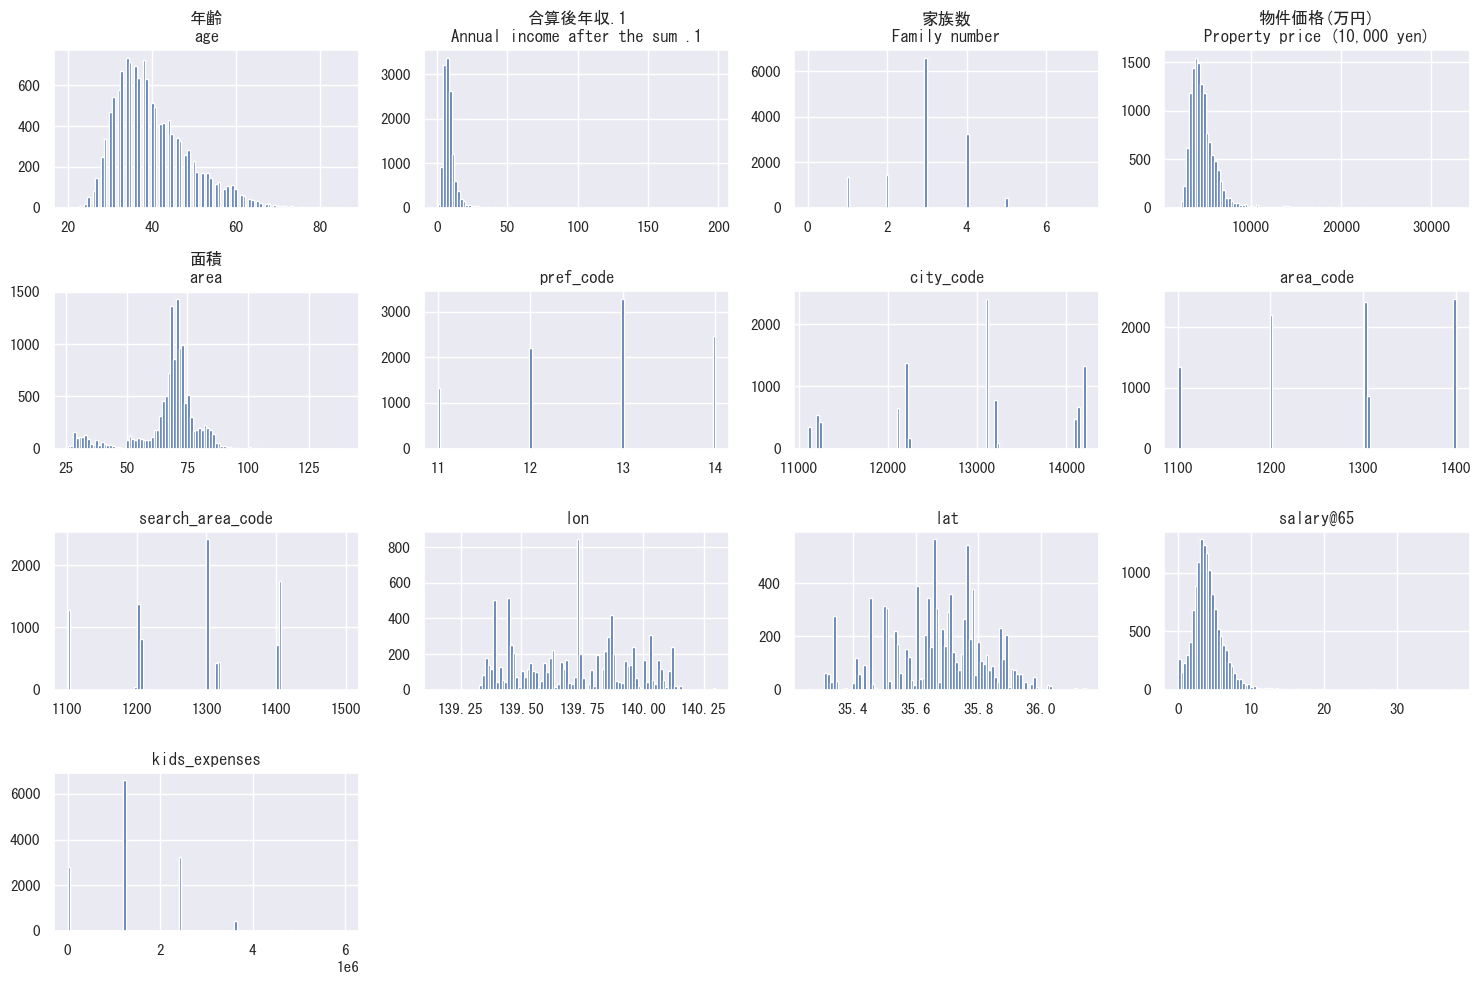

In [52]:
sns.set(font_scale=1.0, font="MS Gothic")
data.hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()

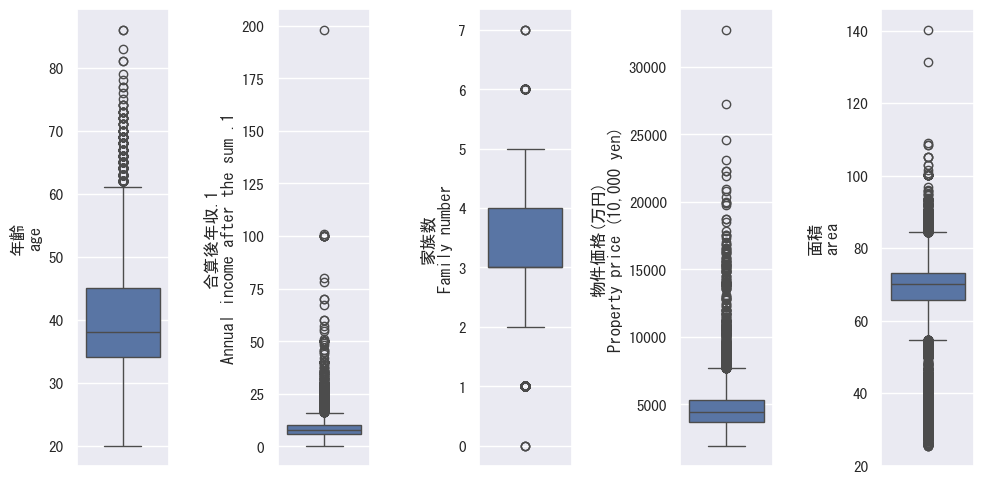

In [53]:
sns.set(font_scale=1.0, font="MS Gothic")
selection = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1','家族数\nFamily number','物件価格(万円)\nProperty price (10,000 yen)','面積\narea']
fig, axes = plt.subplots(1, len(selection),figsize=(10,5))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=data[col], ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

# Expensive house user investigation

7323.0


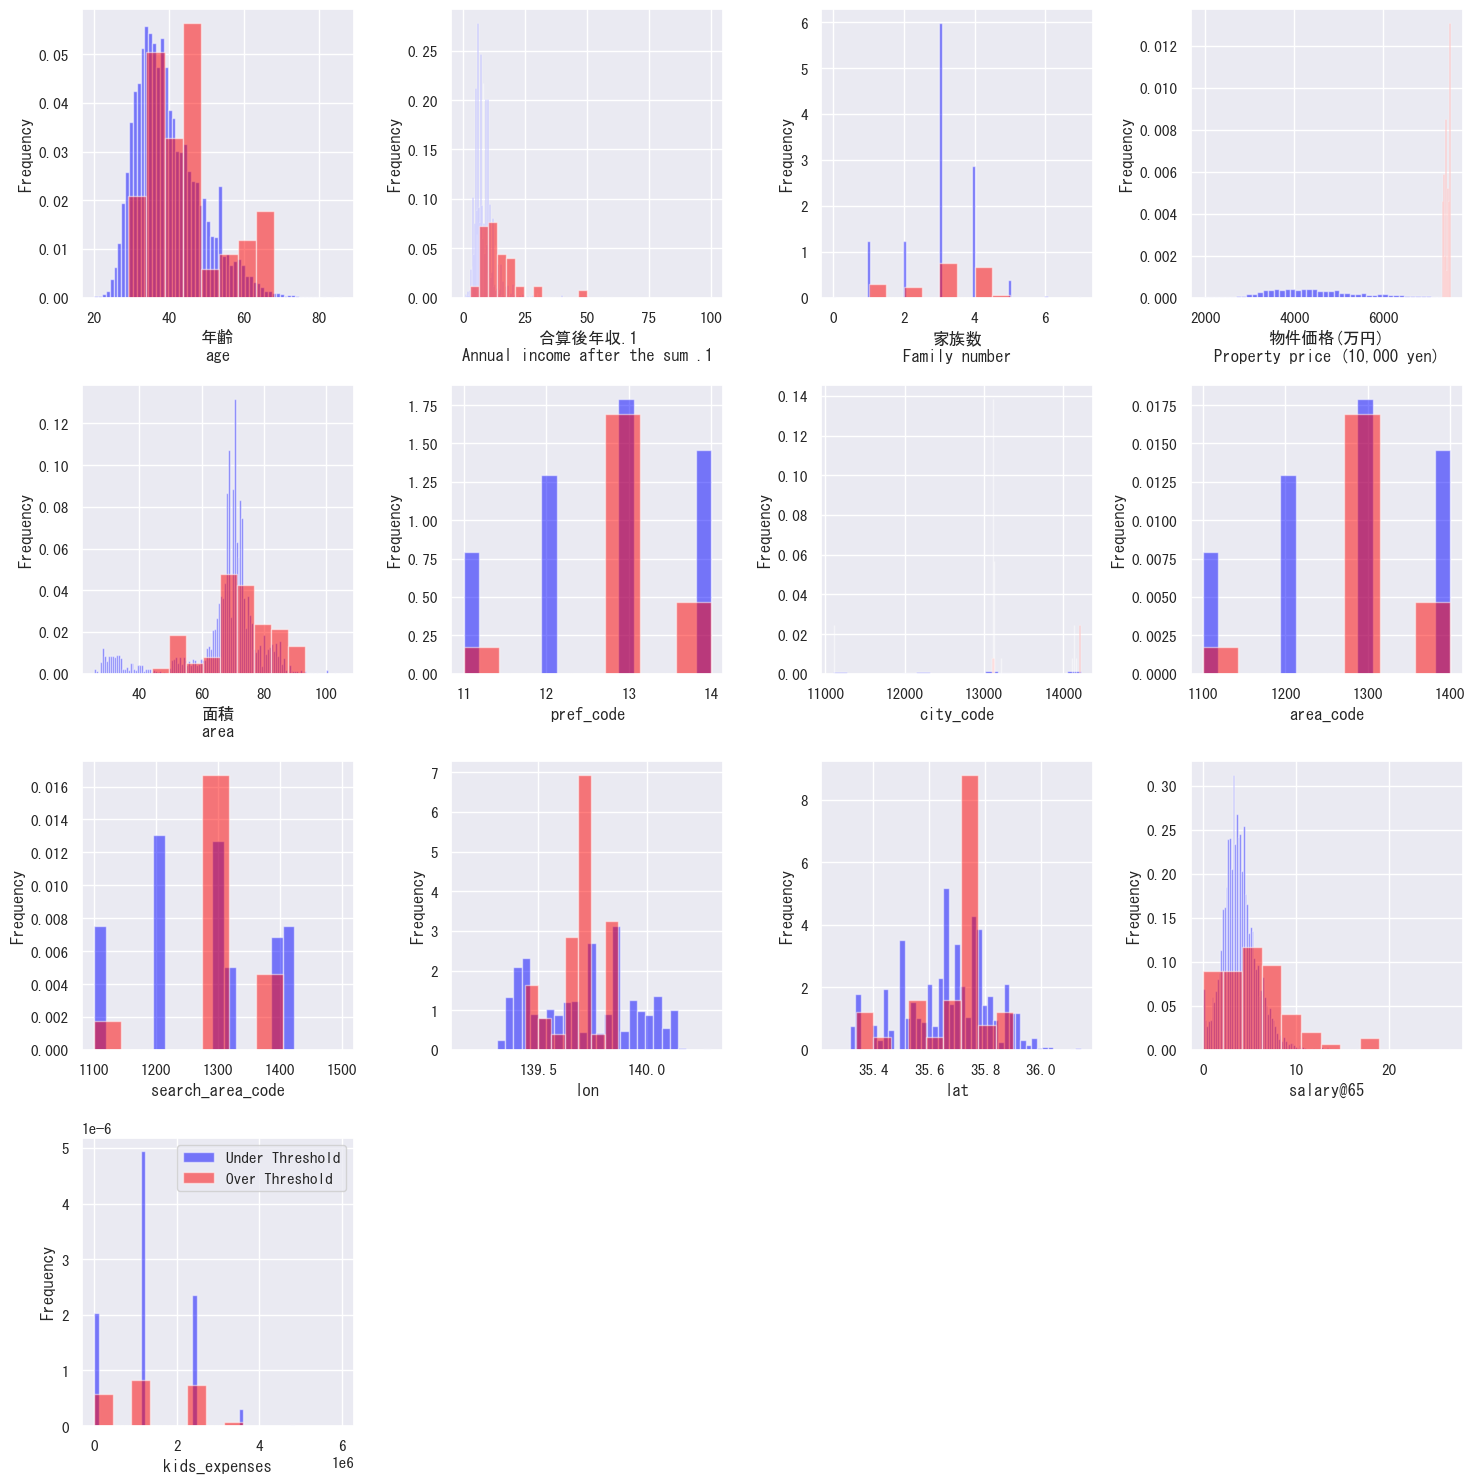

In [13]:
_, max_b = get_boundaries(data, '物件価格(万円)\nProperty price (10,000 yen)')
print(max_b)
over = data[data['物件価格(万円)\nProperty price (10,000 yen)'] >= max_b]
under = data[data['物件価格(万円)\nProperty price (10,000 yen)'] <= max_b]

plt.figure(figsize=(15,15))
for idx, column in enumerate(data.select_dtypes(exclude=['object']).columns):
    plt.subplot(4,4,idx+1)
    plt.hist(under[column], bins='auto', alpha=0.5, label='Under Threshold', color='blue', density=True)
    plt.hist(over[column], bins='auto', alpha=0.5, label='Over Threshold', color='red', density=True)
    plt.xlabel(column)
    plt.ylabel('Frequency')

sns.set(font_scale=1.0, font="MS Gothic")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
under.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  12423.000000                             12423.000000   
mean      39.854866                                 8.297813   
std        8.728537                                 4.232023   
min       20.000000                                 0.360000   
25%       33.000000                                 6.000000   
50%       38.000000                                 7.500000   
75%       45.000000                                10.000000   
max       86.000000                               100.000000   

       家族数\nFamily number  物件価格(万円)\nProperty price (10,000 yen)  \
count        12423.000000                           12423.000000   
mean             3.001771                            4486.277941   
std              0.959490                            1031.734695   
min              0.000000                            1950.000000   
25%              3.000000                            3695.500000   
50%              3.000000                            4341.530000   
75%              4.000000                            5128.000000   
max              7.000000                            7323.000000   

           面積\narea    pref_code     city_code    area_code  search_area_code  \
count  12423.000000  8992.000000   8992.000000  8992.000000       8992.000000   
mean      67.121182    12.733319  12902.096197  1274.412144       1278.577291   
std       12.710861     1.019032   1010.734174   102.197421        102.255790   
min       25.510000    11.000000  11101.000000  1100.000000       1101.000000   
25%       65.770000    12.000000  12204.000000  1200.000000       1202.000000   
50%       70.180000    13.000000  13117.000000  1303.000000       1303.000000   
75%       73.100000    14.000000  14107.000000  1400.000000       1403.000000   
max      105.000000    14.000000  14218.000000  1400.000000       1499.000000   

               lon          lat     salary@65  kids_expenses  
count  8992.000000  8992.000000  12423.000000   1.242300e+04  
mean    139.712599    35.669633      3.975819   1.327602e+06  
std       0.232544     0.153217      1.972957   9.258504e+05  
min     139.155772    35.256225      0.000000   0.000000e+00  
25%     139.472653    35.568784      2.762900   1.200000e+06  
50%     139.726858    35.688770      3.750000   1.200000e+06  
75%     139.881158    35.777117      4.950000   2.400000e+06  
max     140.297838    36.142397     26.640000   6.000000e+06

In [15]:
over.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  家族数\nFamily number  \
count  69.00000                                69.000000           69.000000   
mean   44.26087                                14.485318            2.985507   
std     9.96413                                 8.289551            1.077753   
min    29.00000                                 2.900000            1.000000   
25%    36.00000                                10.000000            2.000000   
50%    43.00000                                12.000000            3.000000   
75%    48.00000                                17.500000            4.000000   
max    68.00000                                50.000000            5.000000   

       物件価格(万円)\nProperty price (10,000 yen)   面積\narea  pref_code  \
count                              69.000000  69.000000  40.000000   
mean                             7424.348157  71.669565  13.050000   
std                                57.949685  11.003719   0.714322   
min                              7323.000000  44.160000  11.000000   
25%                              7380.000000  67.180000  13.000000   
50%                              7434.850000  72.010000  13.000000   
75%                              7480.000000  79.270000  13.000000   
max                              7500.000000  93.200000  14.000000   

          city_code   area_code  search_area_code         lon        lat  \
count     40.000000    40.00000         40.000000   40.000000  40.000000   
mean   13177.075000  1307.10000       1308.225000  139.703669  35.696815   
std      728.716764    71.29455         72.062824    0.121596   0.141311   
min    11105.000000  1100.00000       1101.000000  139.437836  35.336847   
25%    13117.000000  1303.00000       1303.000000  139.630601  35.655332   
50%    13117.000000  1303.00000       1303.000000  139.738090  35.754157   
75%    13122.250000  1303.00000       1303.000000  139.743628  35.764531   
max    14205.000000  1400.00000       1405.000000  139.867173  35.900124   

       salary@65  kids_expenses  
count  69.000000   6.900000e+01  
mean    5.635840   1.356522e+06  
std     3.898937   1.006374e+06  
min     0.000000   0.000000e+00  
25%     2.800000   0.000000e+00  
50%     5.600000   1.200000e+06  
75%     7.395000   2.400000e+06  
max    19.000000   3.600000e+06

# High salary house investigation

In [16]:
data.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  12491.000000                             12491.000000   
mean      39.878873                                 8.331776   
std        8.741761                                 4.289102   
min       20.000000                                 0.360000   
25%       33.000000                                 6.000000   
50%       38.000000                                 7.500000   
75%       45.000000                                10.000000   
max       86.000000                               100.000000   

       家族数\nFamily number  物件価格(万円)\nProperty price (10,000 yen)  \
count        12491.000000                           12491.000000   
mean             3.001601                            4502.280672   
std              0.960133                            1051.421514   
min              0.000000                            1950.000000   
25%              3.000000                            3698.000000   
50%              3.000000                            4348.000000   
75%              4.000000                            5148.000000   
max              7.000000                            7500.000000   

           面積\narea    pref_code     city_code    area_code  search_area_code  \
count  12491.000000  9032.000000   9032.000000  9032.000000       9032.000000   
mean      67.145890    12.734721  12903.313995  1274.556909       1278.708592   
std       12.706576     1.018073   1009.794746   102.101493        102.157896   
min       25.510000    11.000000  11101.000000  1100.000000       1101.000000   
25%       65.790000    12.000000  12204.000000  1200.000000       1202.000000   
50%       70.180000    13.000000  13117.000000  1303.000000       1303.000000   
75%       73.115000    14.000000  14107.000000  1400.000000       1403.000000   
max      105.000000    14.000000  14218.000000  1400.000000       1499.000000   

               lon          lat     salary@65  kids_expenses  
count  9032.000000  9032.000000  12491.000000   1.249100e+04  
mean    139.712559    35.669753      3.984937   1.327676e+06  
std       0.232167     0.153170      1.992294   9.262605e+05  
min     139.155772    35.256225      0.000000   0.000000e+00  
25%     139.472653    35.568784      2.762900   1.200000e+06  
50%     139.726858    35.689073      3.755400   1.200000e+06  
75%     139.878344    35.776380      4.960000   2.400000e+06  
max     140.297838    36.142397     26.640000   6.000000e+06

In [19]:
data_sankey = data.copy()

# data_sankey['income_quartile'] = pd.qcut(data_sankey['合算後年収.1\nAnnual income after the sum .1'],4,labels=['<600万円', '600万円-720万円', '720万円-980万円', '>980万円'])
data_sankey['income_group'] = pd.cut(data_sankey['合算後年収.1\nAnnual income after the sum .1'],
                                         bins=[0, 5, 7.5, 10, 12.5, 100],
                                         labels=['<500万円', '500万円-750万円', '750万円-1000万円', '1000万円-1250万円', '>1250万円'])
data_sankey['price_group'] = pd.cut(data_sankey['物件価格(万円)\nProperty price (10,000 yen)'],
                                    bins=[0, 2000, 3000, 4000, 5000, 6000, 7000, 8000],
                                    labels=['<2000万円', '2000万円-3000万円', '3000万円-4000万円', '4000万円-5000万円','5000万円-6000万円','6000万円-7000万円','7000万円-8000万円'])
# data_sankey['age_group'] = pd.cut(data_sankey['年齢\nage'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-50', '>60'])
# data_sankey['family_category'] = pd.cut(data_sankey['家族数\nFamily number'], bins=[0, 1, 2, 100], labels=['1', '2', '3+'], right=False)

# # Aggregate data for Salary Quartiles → Age Groups
# income_to_age = data_sankey.groupby(['income_quartile', 'age_group']).size().reset_index(name='count')
income_to_price = data_sankey.groupby(['income_group', 'price_group']).size().reset_index(name='count')
# age_to_family = data_sankey.groupby(['age_group', 'family_category']).size().reset_index(name='count')

# Initialize lists to hold our source-target-value data
labels = pd.concat([data_sankey['income_group'], data_sankey['price_group']]).unique()
label_to_index_all = {label: idx for idx, label in enumerate(labels)}

sources_all, targets_all, values_all = [], [], []
for i, row in income_to_price.iterrows():
    sources_all.append(label_to_index_all[row['income_group']])
    targets_all.append(label_to_index_all[row['price_group']])
    values_all.append(row['count'])
    
############

single = data_sankey[data_sankey['家族F\nFamily F']=='独身']
single['income_group'] = pd.cut(single['合算後年収.1\nAnnual income after the sum .1'],
                                         bins=[0, 5, 7.5, 10, 12.5, 100],
                                         labels=['<500万円', '500万円-750万円', '750万円-1000万円', '1000万円-1250万円', '>1250万円'])
single['price_group'] = pd.cut(single['物件価格(万円)\nProperty price (10,000 yen)'],
                                    bins=[0, 2000, 3000, 4000, 5000, 6000, 7000, 8000],
                                    labels=['<2000万円', '2000万円-3000万円', '3000万円-4000万円', '4000万円-5000万円','5000万円-6000万円','6000万円-7000万円','7000万円-8000万円'])
income_to_price = single.groupby(['income_group', 'price_group']).size().reset_index(name='count')
labels = pd.concat([single['income_group'], single['price_group']]).unique()
label_to_index_single = {label: idx for idx, label in enumerate(labels)}

sources_single, targets_single, values_single = [], [], []
for i, row in income_to_price.iterrows():
    sources_single.append(label_to_index_single[row['income_group']])
    targets_single.append(label_to_index_single[row['price_group']])
    values_single.append(row['count'])

##############

couple = data_sankey[data_sankey['家族F\nFamily F']=='独身']
couple['income_group'] = pd.cut(couple['合算後年収.1\nAnnual income after the sum .1'],
                                         bins=[0, 5, 7.5, 10, 12.5, 100],
                                         labels=['<500万円', '500万円-750万円', '750万円-1000万円', '1000万円-1250万円', '>1250万円'])
couple['price_group'] = pd.cut(couple['物件価格(万円)\nProperty price (10,000 yen)'],
                                    bins=[0, 2000, 3000, 4000, 5000, 6000, 7000, 8000],
                                    labels=['<2000万円', '2000万円-3000万円', '3000万円-4000万円', '4000万円-5000万円','5000万円-6000万円','6000万円-7000万円','7000万円-8000万円'])
income_to_price = couple.groupby(['income_group', 'price_group']).size().reset_index(name='count')
labels = pd.concat([couple['income_group'], couple['price_group']]).unique()
label_to_index_couple = {label: idx for idx, label in enumerate(labels)}
sources_couple, targets_couple, values_couple = [], [], []

for i, row in income_to_price.iterrows():
    sources_couple.append(label_to_index_couple[row['income_group']])
    targets_couple.append(label_to_index_couple[row['price_group']])
    values_couple.append(row['count'])

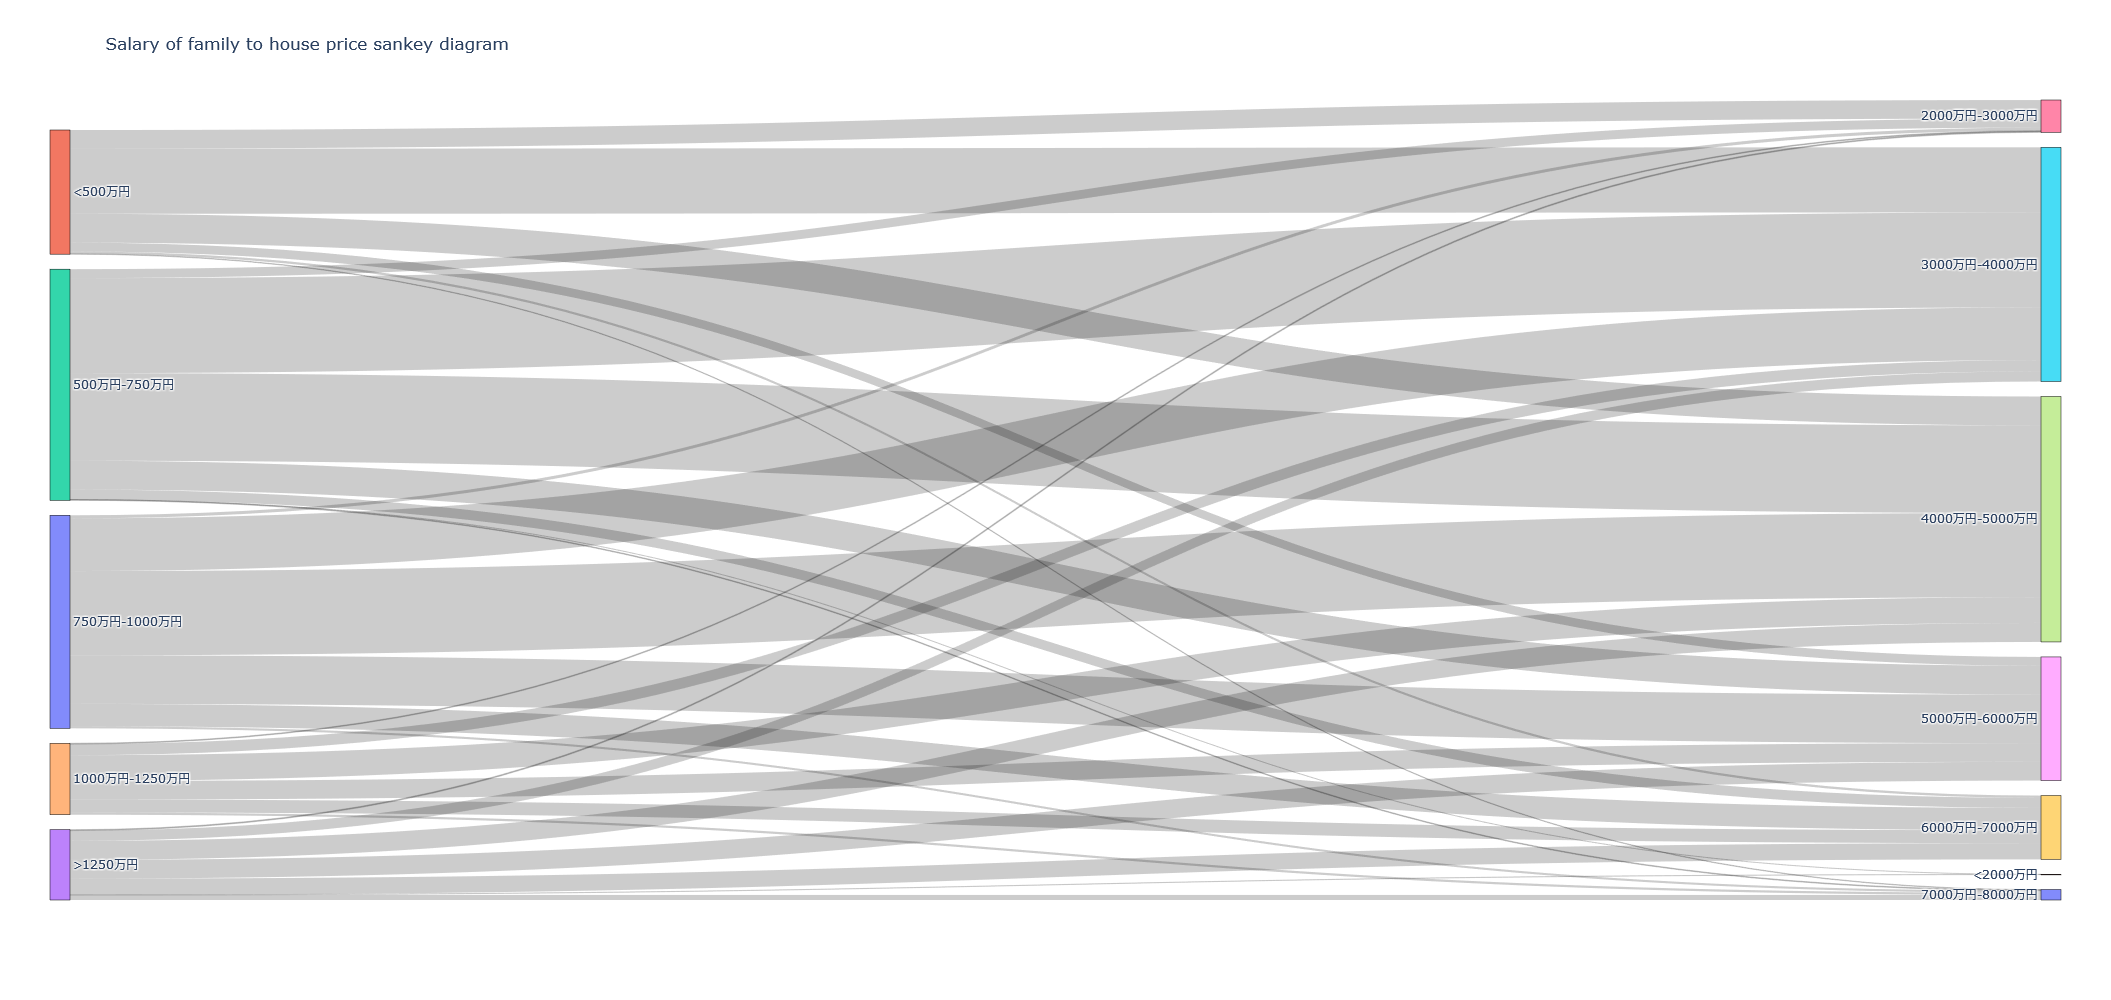

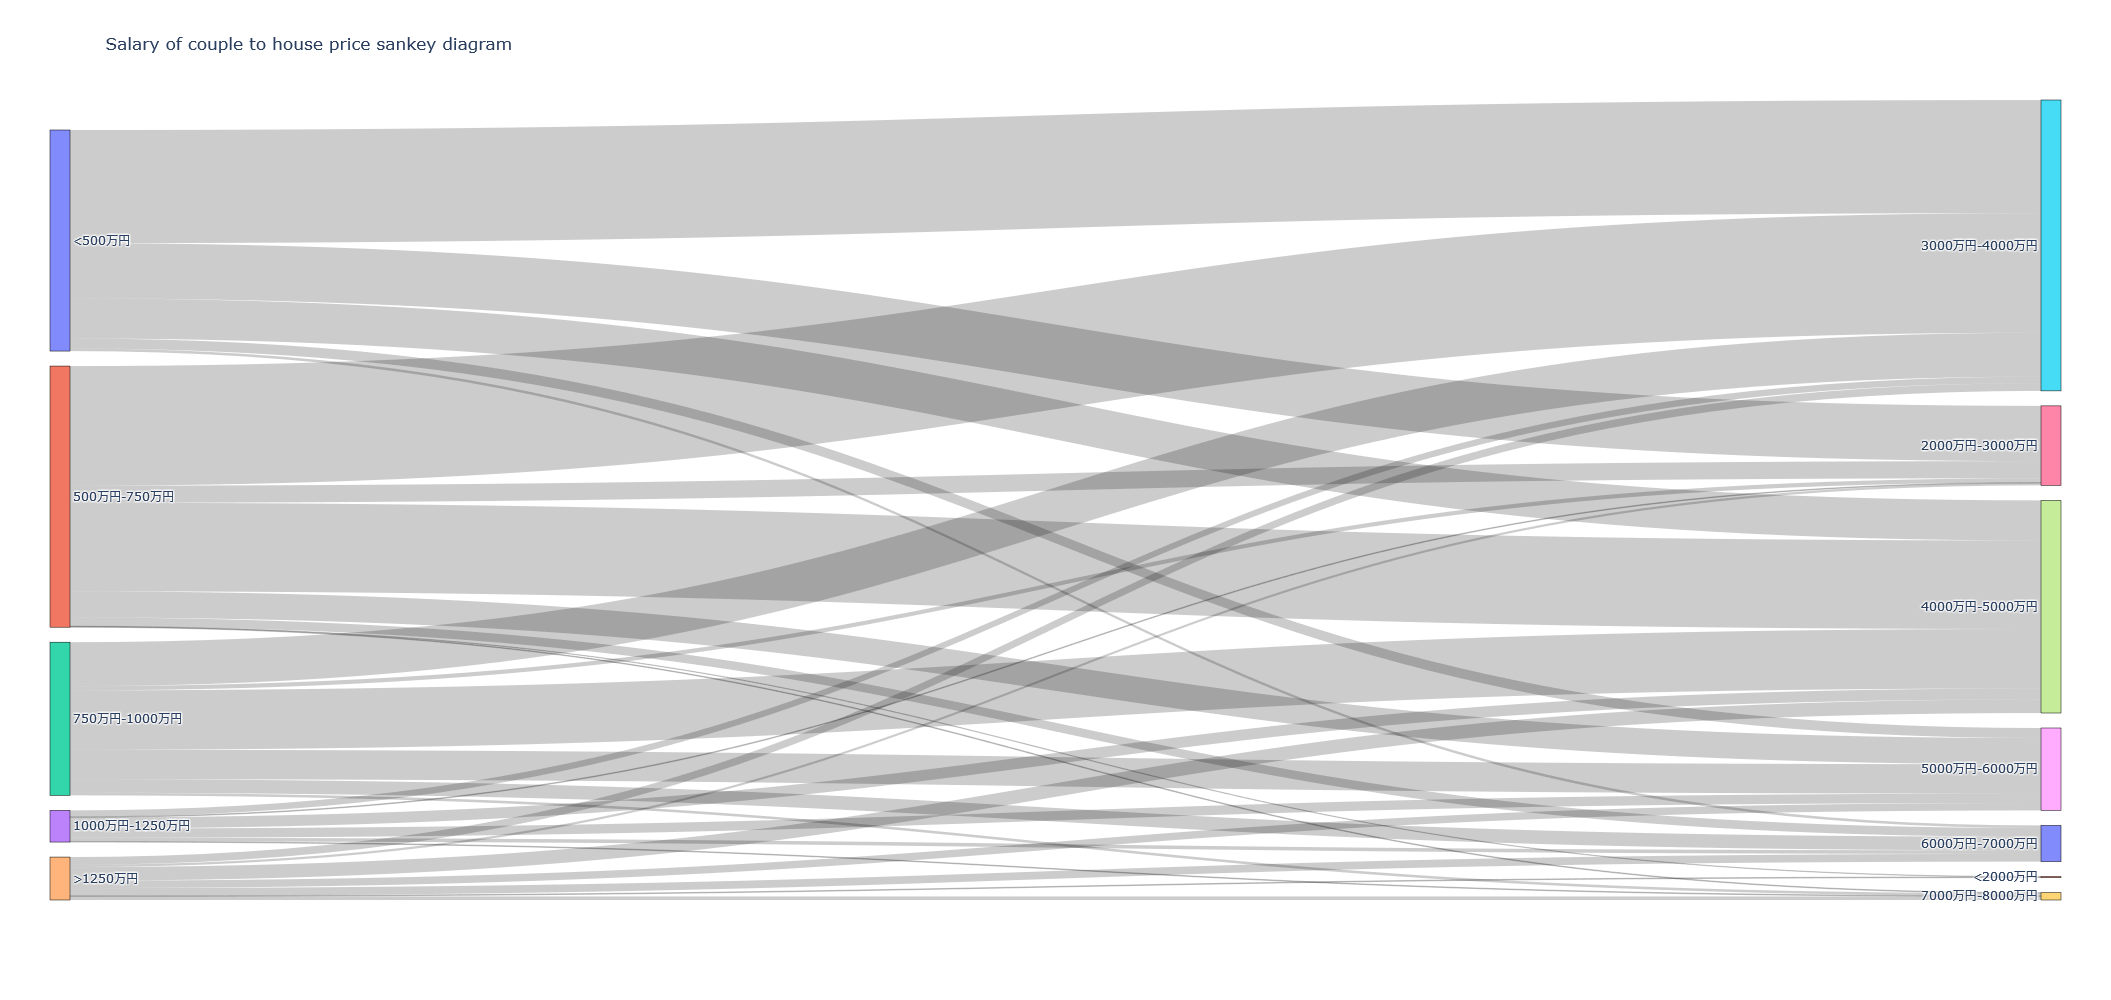

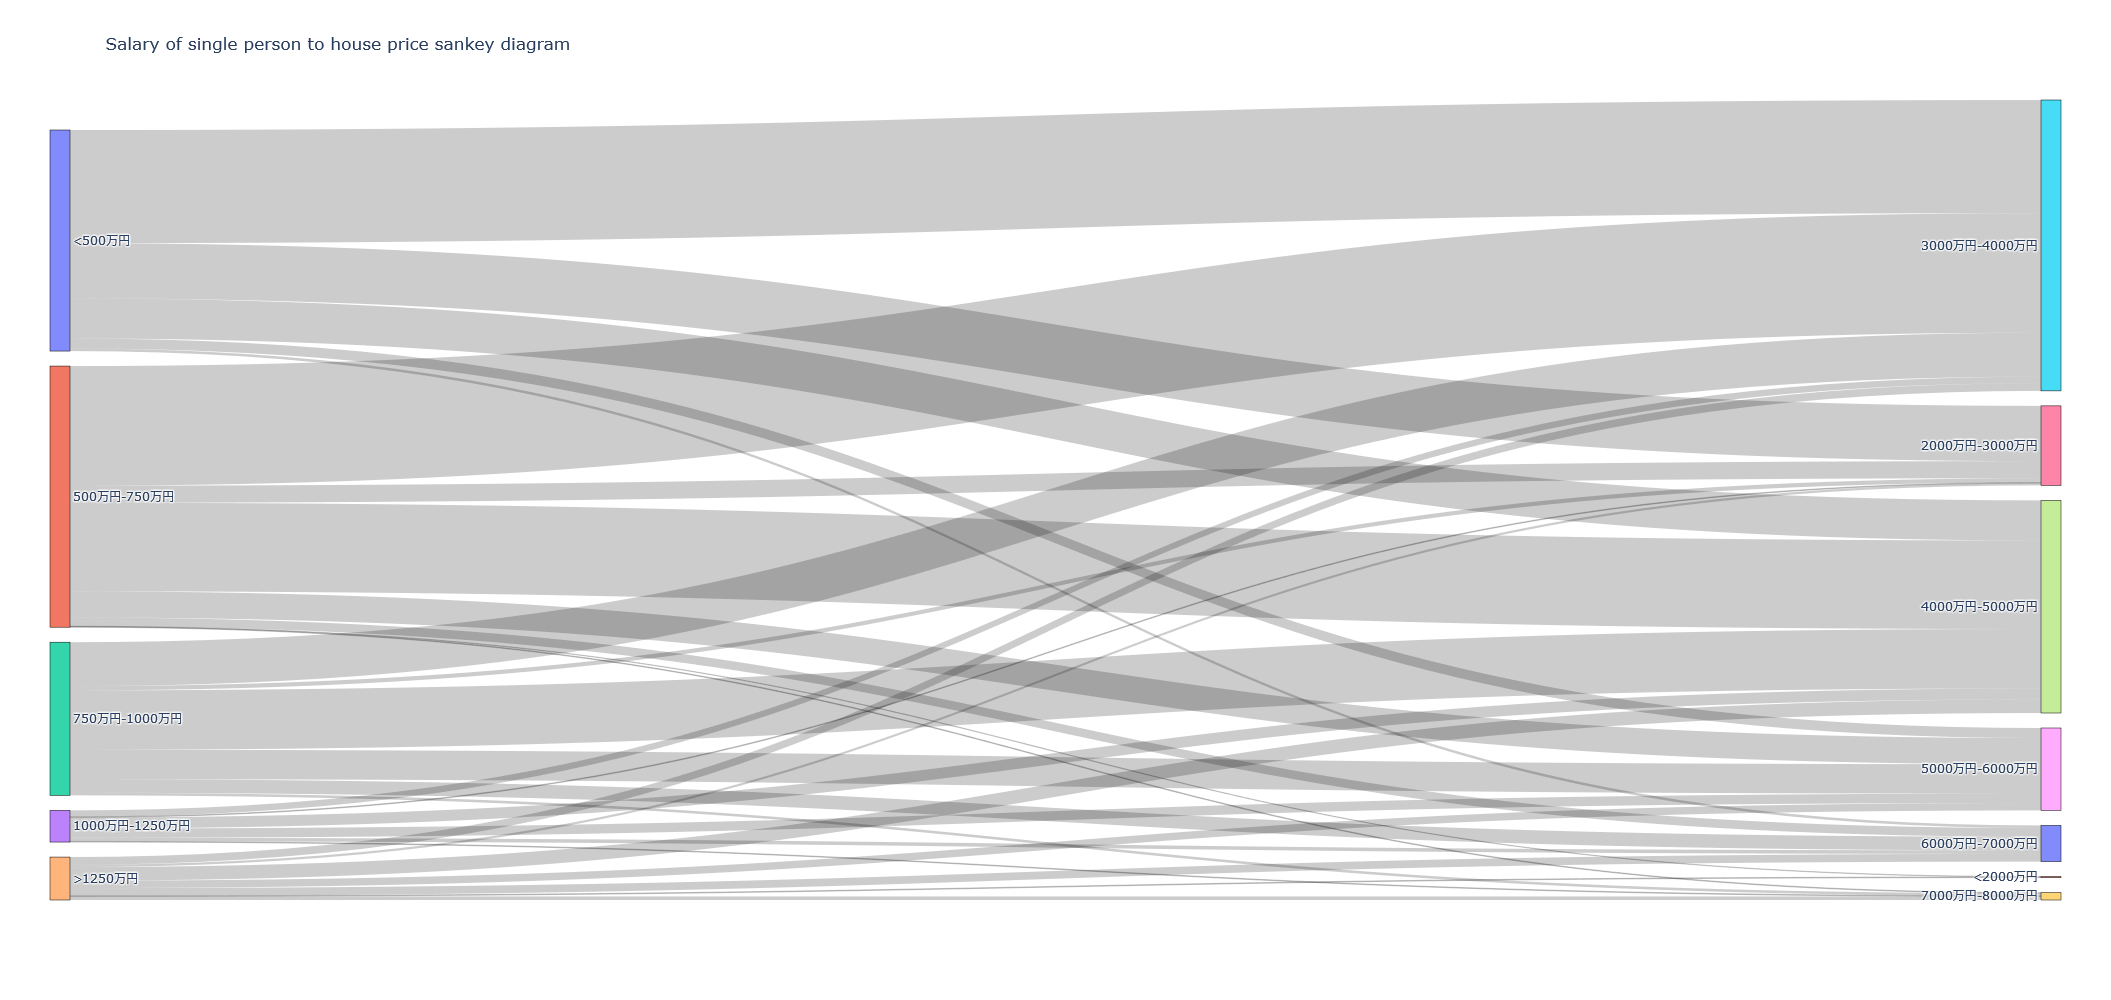

In [20]:
layout = go.Layout(autosize=False, width=1000, height=1000, xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True), yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True), margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),)

fig = go.Figure(data=[go.Sankey(node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=[*label_to_index_all.keys()],),
                                link=dict(source=sources_all, target=targets_all, value=values_all))], layout=layout)
fig.update_layout(title_text="Salary of family to house price sankey diagram", font_size=12)
fig.show()
fig = go.Figure(data=[go.Sankey(node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=[*label_to_index_couple.keys()],),
                                link=dict(source=sources_couple, target=targets_couple, value=values_couple))],
                layout=layout)
fig.update_layout(title_text="Salary of couple to house price sankey diagram", font_size=12)
fig.show()
fig = go.Figure(data=[go.Sankey(node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=[*label_to_index_single.keys()],),
                                link=dict(source=sources_single, target=targets_single, value=values_single))],
                layout=layout)
fig.update_layout(title_text="Salary of single person to house price sankey diagram", font_size=12)
fig.show()

16.0


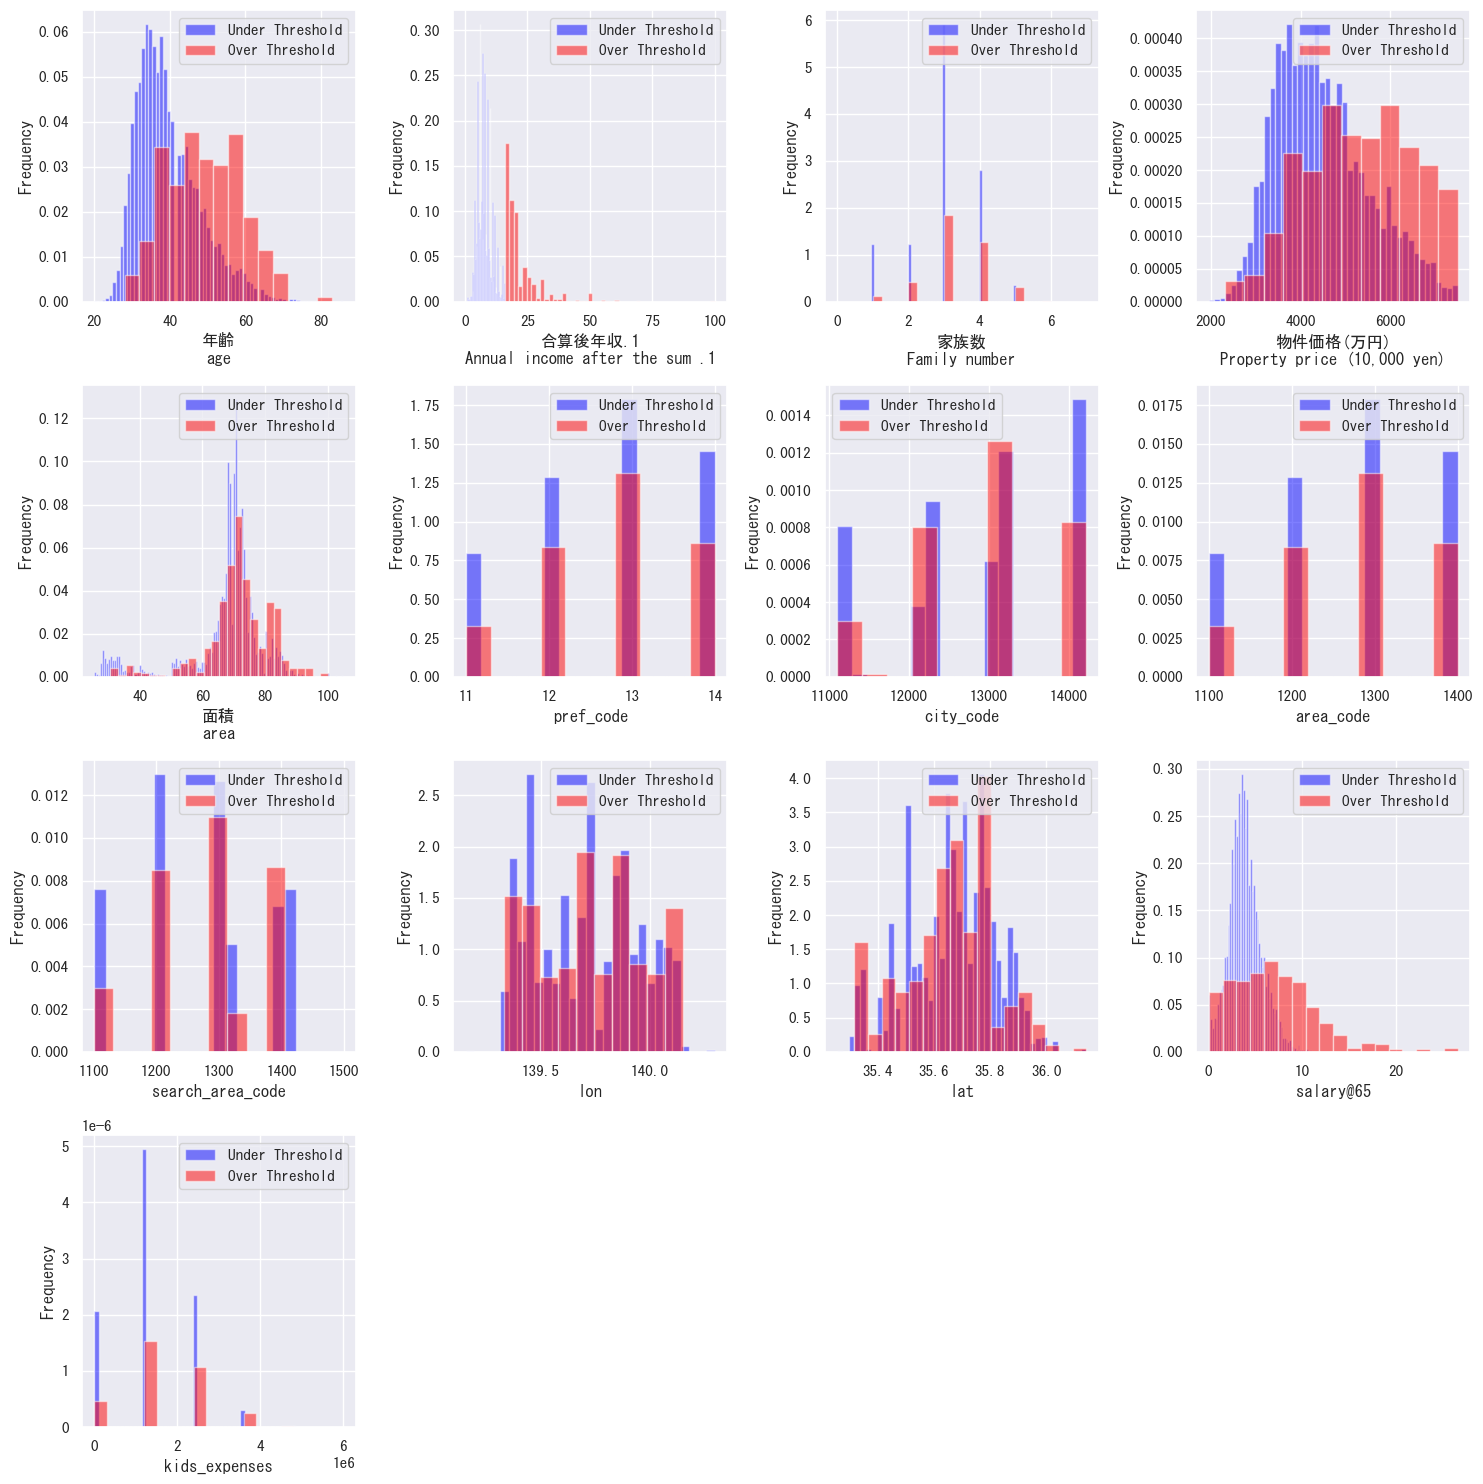

In [21]:
_, max_b = get_boundaries(data, '合算後年収.1\nAnnual income after the sum .1')
print(max_b)
over = data[data['合算後年収.1\nAnnual income after the sum .1'] >= max_b]
under = data[data['合算後年収.1\nAnnual income after the sum .1'] <= max_b]

plt.figure(figsize=(15,15))
for idx, column in enumerate(data.select_dtypes(exclude=['object']).columns):
    plt.subplot(4,4,idx+1)
    plt.hist(under[column], bins='auto', alpha=0.5, label='Under Threshold', color='blue', density=True)
    plt.hist(over[column], bins='auto', alpha=0.5, label='Over Threshold', color='red', density=True)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

sns.set(font_scale=1.0, font="MS Gothic")
plt.tight_layout()
plt.show()

In [22]:
under.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  12047.000000                             12047.000000   
mean      39.524197                                 7.785798   
std        8.481155                                 2.771259   
min       20.000000                                 0.360000   
25%       33.000000                                 5.954252   
50%       38.000000                                 7.400000   
75%       44.000000                                 9.500000   
max       86.000000                                16.000000   

       家族数\nFamily number  物件価格(万円)\nProperty price (10,000 yen)  \
count        12047.000000                           12047.000000   
mean             2.990371                            4473.023095   
std              0.960747                            1033.365948   
min              0.000000                            1950.000000   
25%              3.000000                            3682.327500   
50%              3.000000                            4318.000000   
75%              4.000000                            5098.000000   
max              7.000000                            7500.000000   

           面積\narea    pref_code     city_code    area_code  search_area_code  \
count  12047.000000  8675.000000   8675.000000  8675.000000       8675.000000   
mean      66.980476    12.731182  12900.176945  1274.199769       1278.346167   
std       12.755408     1.021055   1012.609575   102.401769        102.471156   
min       25.510000    11.000000  11101.000000  1100.000000       1101.000000   
25%       65.640000    12.000000  12204.000000  1200.000000       1202.000000   
50%       70.140000    13.000000  13117.000000  1303.000000       1303.000000   
75%       73.010000    14.000000  14107.000000  1400.000000       1403.000000   
max      105.000000    14.000000  14218.000000  1400.000000       1499.000000   

               lon          lat     salary@65  kids_expenses  
count  8675.000000  8675.000000  12047.000000   1.204700e+04  
mean    139.711998    35.670373      3.876343   1.317440e+06  
std       0.231698     0.152781      1.720458   9.222869e+05  
min     139.155772    35.256225      0.000000   0.000000e+00  
25%     139.472653    35.568784      2.760000   1.200000e+06  
50%     139.726858    35.689073      3.720000   1.200000e+06  
75%     139.878344    35.777323      4.860000   2.400000e+06  
max     140.297838    36.142397     11.347200   6.000000e+06

In [23]:
over.describe()

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
count  512.000000                               512.000000   
mean    49.017578                                22.196710   
std      9.955168                                 8.763191   
min     28.000000                                16.000000   
25%     41.000000                                17.000000   
50%     49.000000                                19.035000   
75%     57.000000                                24.000000   
max     83.000000                               100.000000   

       家族数\nFamily number  物件価格(万円)\nProperty price (10,000 yen)    面積\narea  \
count          512.000000                             512.000000  512.000000   
mean             3.322266                            5321.955380   71.677676   
std              0.897732                            1204.180068   10.676793   
min              1.000000                            2310.000000   30.500000   
25%              3.000000                            4413.000000   67.792500   
50%              3.000000                            5346.010000   71.965000   
75%              4.000000                            6266.882500   77.962500   
max              6.000000                            7498.000000  100.170000   

        pref_code     city_code    area_code  search_area_code         lon  \
count  399.000000    399.000000   399.000000        399.000000  399.000000   
mean    12.812030  12970.147870  1282.403509       1286.531328  139.730210   
std      0.930907    926.381216    93.346144         93.107051    0.240213   
min     11.000000  11101.000000  1100.000000       1101.000000  139.329678   
25%     12.000000  12207.000000  1200.000000       1202.000000  139.522728   
50%     13.000000  13117.000000  1303.000000       1303.000000  139.736613   
75%     14.000000  14101.000000  1400.000000       1403.000000  139.888304   
max     14.000000  14218.000000  1400.000000       1405.000000  140.153514   

              lat   salary@65  kids_expenses  
count  399.000000  512.000000   5.120000e+02  
mean    35.657778    6.824580   1.624219e+06  
std      0.157689    4.516017   9.973936e+05  
min     35.316793    0.000000   0.000000e+00  
25%     35.581898    3.520000   1.200000e+06  
50%     35.663554    6.401000   1.200000e+06  
75%     35.763803    9.520000   2.400000e+06  
max     36.142397   26.640000   4.800000e+06

In [24]:
norm_method = 'mean'
continuous_col = ['家族数\nFamily number','年齢\nage','salary@65']
categorical_col = ['家族F\nFamily F', '合算後年収\nAnnual income after the sum']

data_continuous, transform_input = unskew_data(data[continuous_col])
data_continuous, (x_in, y_in) = normalization(data_continuous, norm_method)

encoder = OneHotEncoder(dtype=np.int64, sparse=True)
data_categorical = pd.DataFrame(encoder.fit_transform(data[categorical_col]).toarray(),
                                columns = [i for i in encoder.get_feature_names_out()],
                                index = data.index)

dataframe = pd.concat([data_continuous, data_categorical], axis=1)
# filehandler = open("encoder.obj","wb")
# pickle.dump(encoder,filehandler)
# filehandler.close()

In [25]:
target_col = ['物件価格(万円)\nProperty price (10,000 yen)']
target = data[target_col]

target, transform_output = unskew_data(target)
target, (x_out, y_out) = normalization(target, norm_method)

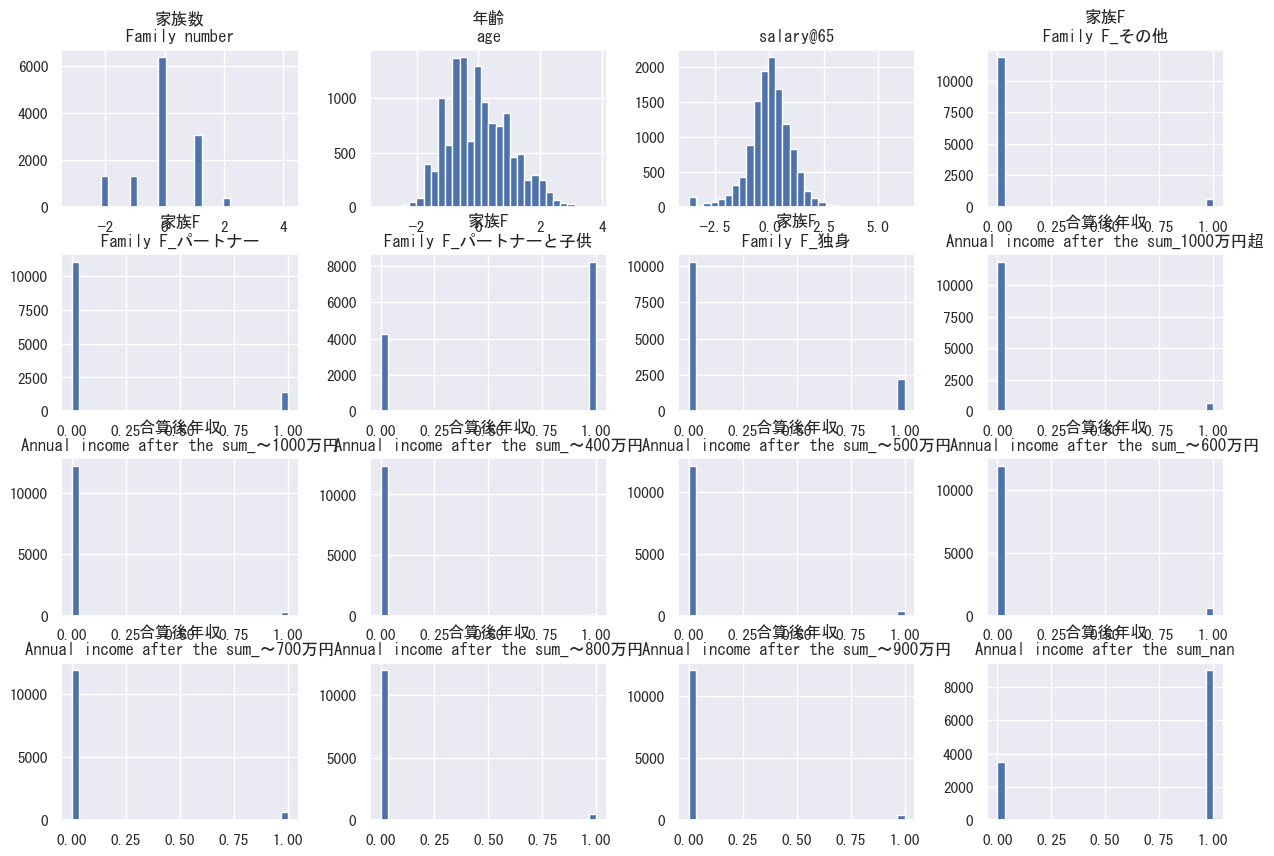

In [26]:
dataframe.hist(bins=30, figsize=(15, 10))
plt.show()

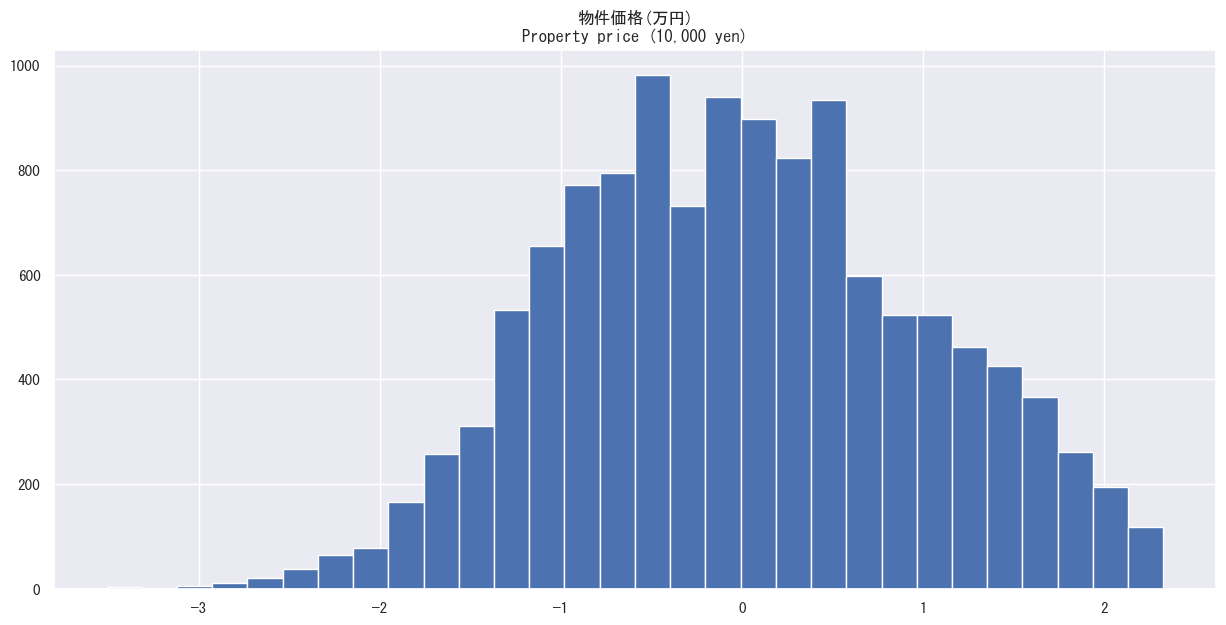

In [27]:
target.hist(bins=30, figsize=(15, 7))
plt.show()

# ML - Price & superficy regression

In [28]:
_, bin_edges = np.histogram(target, density=True)
bin_indices = np.digitize(np.squeeze(target.to_numpy()), bin_edges)
valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
valid_data_indices = np.isin(bin_indices, valid_bins)

filtered_dataframe = dataframe[valid_data_indices]
filtered_target = target[valid_data_indices]
filtered_bin_indices = bin_indices[valid_data_indices]

X_train, X, y_train, y = train_test_split(filtered_dataframe, filtered_target, test_size=0.15, random_state=5, shuffle=True, stratify=filtered_bin_indices)

df_smoter = pd.concat((X_train,y_train), axis=1).reset_index()
smoter = smogn.smoter(data = df_smoter, y = "物件価格(万円)\nProperty price (10,000 yen)")
X_train = smoter[list(filtered_dataframe.columns)]
y_train = smoter[['物件価格(万円)\nProperty price (10,000 yen)']]

r_index: 100%|######################################################################| 372/372 [00:00<00:00, 522.33it/s]


In [29]:
_, bin_edges = np.histogram(y, density=True)
bin_indices = np.digitize(np.squeeze(y), bin_edges)
valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
valid_data_indices = np.isin(bin_indices, valid_bins)

filtered_dataframe = X[valid_data_indices]
filtered_target = y[valid_data_indices]
filtered_bin_indices = bin_indices[valid_data_indices]

X_val, X_test, y_val, y_test = train_test_split(filtered_dataframe, filtered_target, test_size=0.5, random_state=5, shuffle=True, stratify=filtered_bin_indices)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(9911, 16) (9911, 1) (937, 16) (937, 1) (937, 16) (937, 1)


In [30]:
def score_regression(params):
    reg = xgb.XGBRegressor(**params).fit(**fit_params)
    return {'loss': mean_absolute_error(reg.predict(X_test), y_test), 'status': STATUS_OK, 'model': reg}

def optimize_regression(trials, space, tries):
    return fmin(fn=score_regression, space=space, algo=tpe.suggest, max_evals=tries, trials=trials, show_progressbar=True)

def format_params(space, best):
    best['objective'] = obj.get(best['objective'])
    best['max_depth'] += 1
    best['min_child_weight'] += 1
    for k,v in space.items():
        if k not in best.keys():
            best[k] = v
    return best

obj = {0:'reg:squarederror', 1:'reg:pseudohubererror',2:'reg:absoluteerror'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 50,
              'eval_metric': ['rmse','mae'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 50))),
         'min_child_weight': scope.int(hp.choice('min_child_weight', np.arange(1, 50))),
         'subsample': hp.quniform('subsample', 0.1, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.1, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'seed': 0}

trials = Trials()
best = optimize_regression(trials, space, 250)
params = format_params(space, best)
xgb_reg = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|██████████████████████████████████████████████| 250/250 [03:31<00:00,  1.18trial/s, best loss: 0.6881183806721693]

 {'colsample_bytree': 0.7000000000000001, 'eta': 0.17500000000000002, 'gamma': 0.9, 'max_depth': 6, 'min_child_weight': 8, 'objective': 'reg:squarederror', 'subsample': 1.0, 'n_estimators': 1000, 'seed': 0}


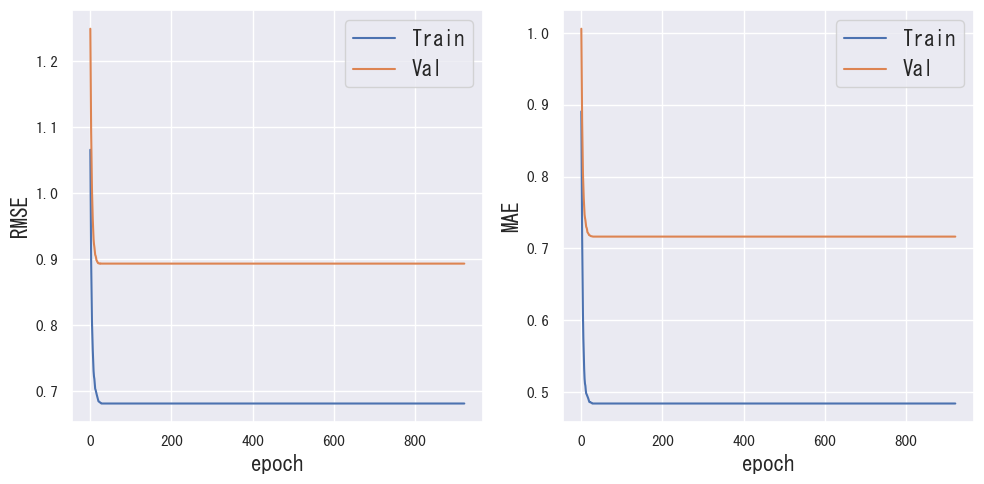

In [31]:
# Training metrics
results = xgb_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)

# Plot classification error
ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
ax2.plot(x_axis, results['validation_1']['mae'], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('MAE', fontsize=15)

plt.tight_layout()

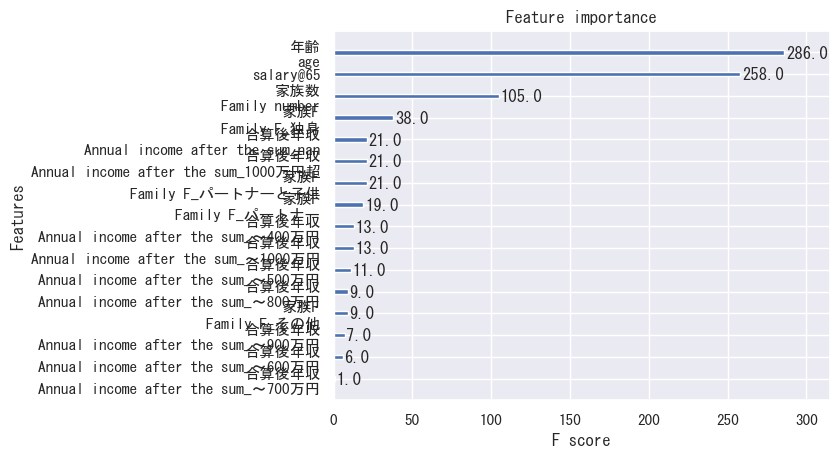

In [32]:
xgb.plot_importance(xgb_reg)
plt.show()

In [33]:
pred = np.expand_dims(xgb_reg.predict(X_test), axis=1)

if norm_method == 'mean': # Mean normalization
    pred = pred * y_out + x_out 
    gt = y_test * y_out + x_out
elif norm_method == 'minmax': # Min Max normalization
    pred = pred * (y_out - x_out) + x_out
    gt = y_test * (y_out - x_out) + x_out

pred = reverse_transform(pred, transform_output)
gt = reverse_transform(gt, transform_output)

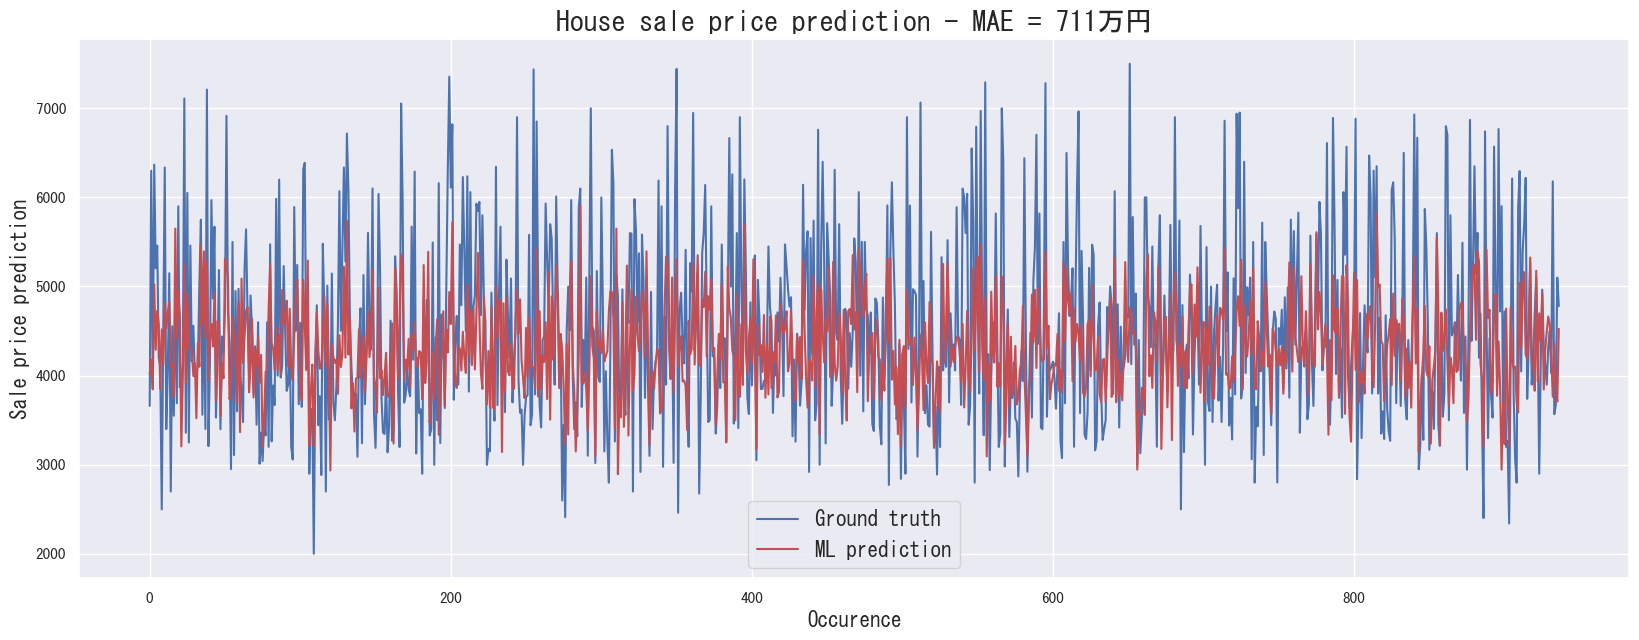

In [34]:
plt.figure(figsize=(20,7))
d = {'Ground truth': gt, 'Pred': pred}
res_pred = pd.DataFrame(data=d).reset_index()
mae = mean_absolute_error(gt, pred)

# # Plotting results
plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
plt.xlabel('Occurence', fontsize=15)
plt.ylabel('Sale price prediction', fontsize=15)
plt.title('House sale price prediction - MAE = %s万円'%(format(int(mae),',d')), fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [35]:
price_range = [price > pred[idx] - 1.0 * mae and price <  pred[idx] + 1.0*mae for idx, price in enumerate(gt)]
print(sum(price_range)/len(price_range))

0.5944503735325507


In [36]:
excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
borrowed = pd.read_excel(unlocked_file)

borrowed.columns = [unicodedata.normalize('NFKC', s) for s in borrowed.columns]
borrowed.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in borrowed.columns]
borrowed = borrowed[['借入金額(百万円単位)\nBorrowed amount (million yen units)']]

borrowed['借入金額(百万円単位)\nBorrowed amount (million yen units)'] *= 100
borrowed = borrowed.rename(columns={'借入金額(百万円単位)\nBorrowed amount (million yen units)':'借入金額(万円)\nBorrowed amount'})

In [37]:
false_indices = [index for index, value in enumerate(price_range) if value == False]
error_price_index = X_test.index[false_indices]
verification_price = data.loc[error_price_index,:]
verification_price['GT'] = gt.to_numpy()[false_indices]
verification_price['prediction'] = pred[false_indices]
verification_price = verification_price.sort_values(by='GT', ascending=False)

verification_price = pd.merge(verification_price, borrowed, left_index=True, right_index=True, how='left')

# 合算後年収.1\nAnnual income after the sum .1
# GT
# prediction
# 借入金額(百万円単位)\nBorrowed amount (million yen units)

verification_price.head(15)

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
9215      29.0                                    15.76   
8873      35.0                                    16.00   
8893      65.0                                    23.00   
2228      30.0                                     9.00   
208       33.0                                     9.00   
1513      48.0                                    18.00   
12008     39.0                                    15.04   
2865      46.0                                    15.00   
9550      53.0                                    13.00   
1098      39.0                                    11.00   
9075      36.0                                    11.30   
8954      37.0                                    12.00   
3546      49.0                                    16.85   
9181      37.0                                     7.50   
9273      36.0                                     8.20   

      合算後年収\nAnnual income after the sum  家族数\nFamily number 家族F\nFamily F  \
9215                                 NaN                   4           その他   
8873                                 NaN                   3      パートナーと子供   
8893                                 NaN                   3           その他   
2228                              ～900万円                   2         パートナー   
208                              ～1000万円                   2         パートナー   
1513                             1000万円超                   2         パートナー   
12008                                NaN                   4      パートナーと子供   
2865                             1000万円超                   3      パートナーと子供   
9550                                 NaN                   3      パートナーと子供   
1098                             1000万円超                   4      パートナーと子供   
9075                                 NaN                   3      パートナーと子供   
8954                                 NaN                   3      パートナーと子供   
3546                                 NaN                   4      パートナーと子供   
9181                                 NaN                   4      パートナーと子供   
9273                                 NaN                   2         パートナー   

       物件価格(万円)\nProperty price (10,000 yen)  面積\narea    LP名\nLP name  \
9215                                7498.000     76.86           バウス金町   
8873                                7440.387     72.01     ガーデンクロス東京王子   
8893                                7434.850     72.01     ガーデンクロス東京王子   
2228                                7353.000     65.54   マンション中心のLPの案件   
208                                 7290.000     52.71   マンション中心のLPの案件   
1513                                7280.000     51.73   マンション中心のLPの案件   
12008                               7208.000     72.90  ルピアコート大宮　ザ・ゲート   
2865                                7108.000     62.28   マンション中心のLPの案件   
9550                                7062.510     81.59   リビオシティ西葛西親水公園   
1098                                7052.000     51.20       今回追加したデータ   
9075                                6998.000     67.18       ローレルコート赤羽   
8954                                6998.000     71.32     ガーデンクロス東京王子   
3546                                6968.000     85.09     ザ・ガーデンズ東京王子   
9181                                6963.010     76.86           バウス金町   
9273                                6950.000     70.21           ジオ新丸子   

                  最新住所\nLatest address  pref_code pref_name  city_code  \
9215                               NaN       13.0       東京都    13122.0   
8873                               NaN       13.0       東京都    13117.0   
8893                               NaN       13.0       東京都    13117.0   
2228   川崎市中原区　木月住吉町　２９－１１　プラウド元住吉ガーデンズ        NaN       NaN        NaN   
208       横浜市西区　岡野　１－１７－１５　プラウド横浜岡野１丁目        NaN       NaN        NaN   
1513   東京都　杉並区　西荻北　３－９－１　オープンレジデンシア西荻窪        NaN       NaN        NaN   
12008                              NaN       11.0       埼玉県    11105.0   
2865       東京都　文京区　千駄木　５－３８－８　リビオ文京千

# Superficy modelling

In [38]:
target_col = ['面積\narea']
target = data[target_col]

target, transform_output = unskew_data(target)
target, (x_out, y_out) = normalization(target, norm_method)

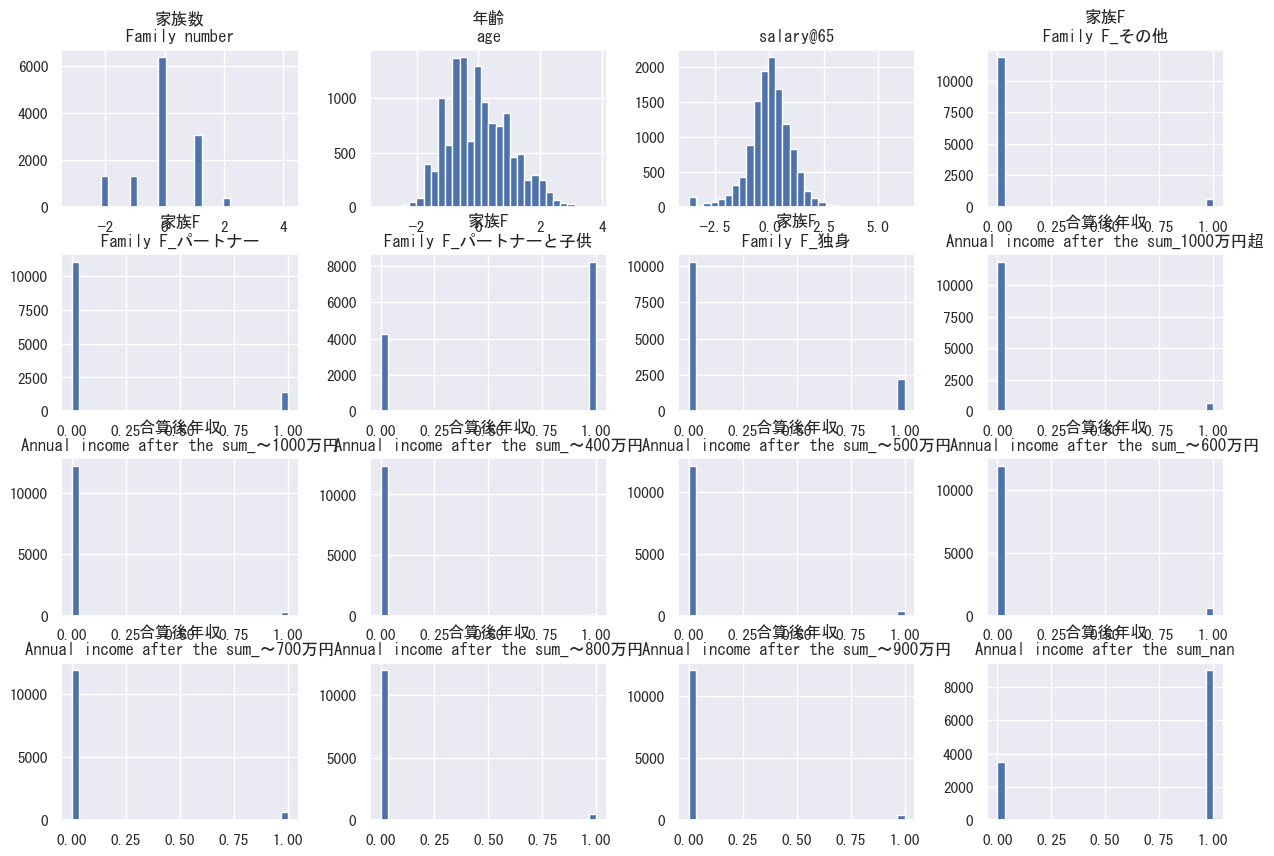

In [39]:
dataframe.hist(bins=30, figsize=(15, 10))
plt.show()

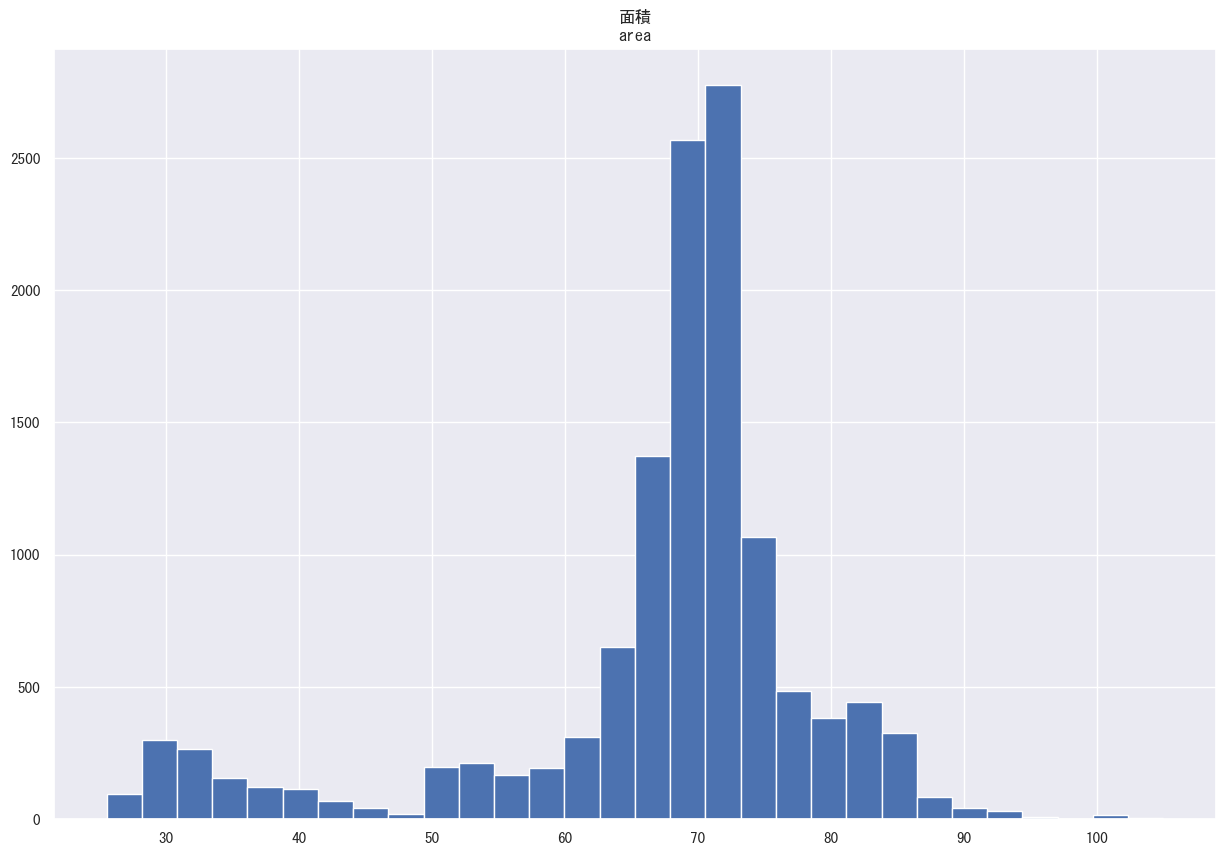

In [40]:
data[target_col].hist(bins=30, figsize=(15, 10))
plt.show()

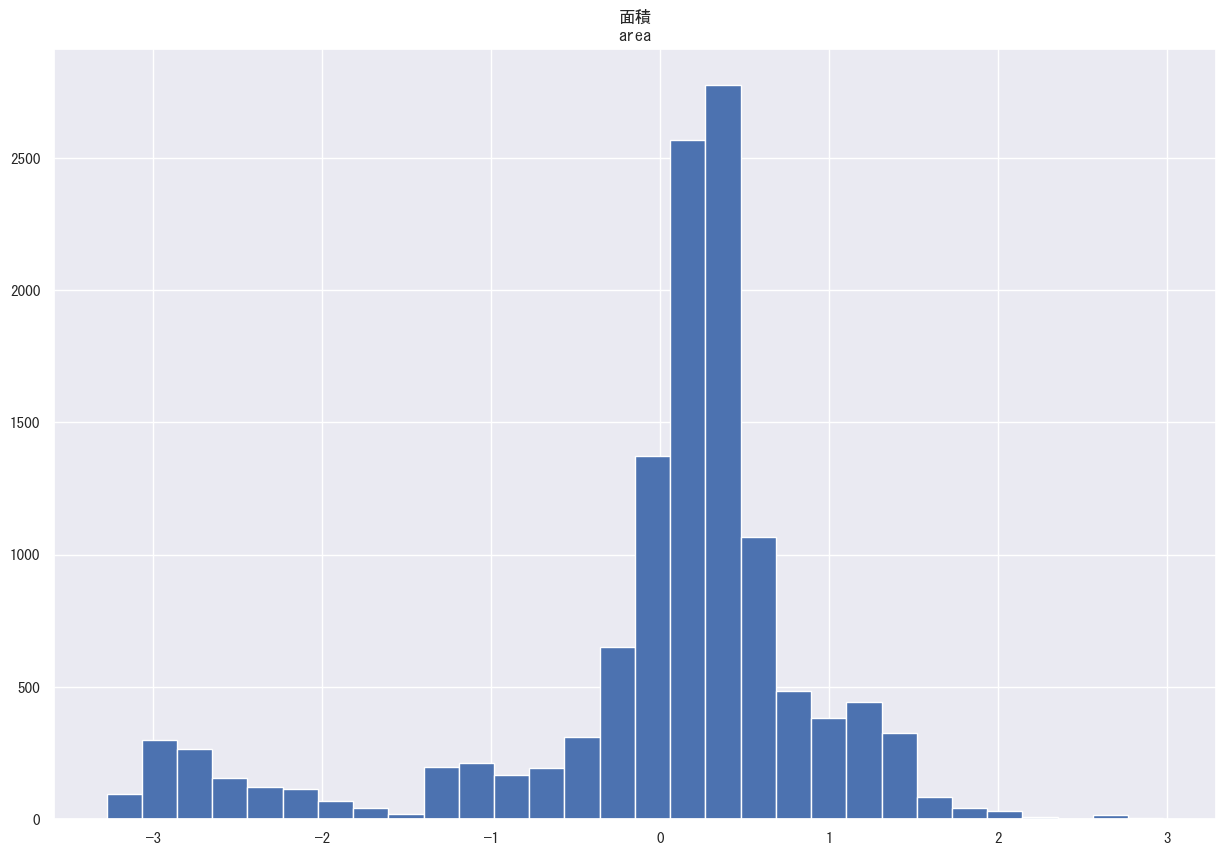

In [41]:
target.hist(bins=30, figsize=(15, 10))
plt.show()

In [42]:
_, bin_edges = np.histogram(target, density=True)
bin_indices = np.digitize(np.squeeze(target.to_numpy()), bin_edges)
valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
valid_data_indices = np.isin(bin_indices, valid_bins)

filtered_dataframe = dataframe[valid_data_indices]
filtered_target = target[valid_data_indices]
filtered_bin_indices = bin_indices[valid_data_indices]

X_train, X, y_train, y = train_test_split(filtered_dataframe, filtered_target, test_size=0.15, random_state=5, shuffle=True, stratify=filtered_bin_indices)

df_smoter = pd.concat((X_train,y_train), axis=1).reset_index()
smoter = smogn.smoter(data = df_smoter, y = "面積\narea")
X_train = smoter[list(filtered_dataframe.columns)]
y_train = smoter[['面積\narea']]

r_index: 100%|######################################################################| 987/987 [00:01<00:00, 620.31it/s]


In [43]:
_, bin_edges = np.histogram(y, density=True)
bin_indices = np.digitize(np.squeeze(y), bin_edges)
valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
valid_data_indices = np.isin(bin_indices, valid_bins)

filtered_dataframe = X[valid_data_indices]
filtered_target = y[valid_data_indices]
filtered_bin_indices = bin_indices[valid_data_indices]

X_val, X_test, y_val, y_test = train_test_split(filtered_dataframe, filtered_target, test_size=0.5, random_state=5, shuffle=True, stratify=filtered_bin_indices)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(10978, 16) (10978, 1) (936, 16) (936, 1) (937, 16) (937, 1)


In [44]:
obj = {0:'reg:squarederror', 1:'reg:pseudohubererror',2:'reg:absoluteerror'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 50,
              'eval_metric': ['rmse','mae'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 50))),
         'min_child_weight': scope.int(hp.choice('min_child_weight', np.arange(1, 50))),
         'subsample': hp.quniform('subsample', 0.1, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.1, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'seed': 0}

trials = Trials()
best = optimize_regression(trials, space, 250)
params = format_params(space, best)
xgb_reg = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|██████████████████████████████████████████████| 250/250 [02:22<00:00,  1.76trial/s, best loss: 0.4172555700563837]

 {'colsample_bytree': 0.75, 'eta': 0.25, 'gamma': 0.1, 'max_depth': 19, 'min_child_weight': 33, 'objective': 'reg:absoluteerror', 'subsample': 0.8500000000000001, 'n_estimators': 1000, 'seed': 0}


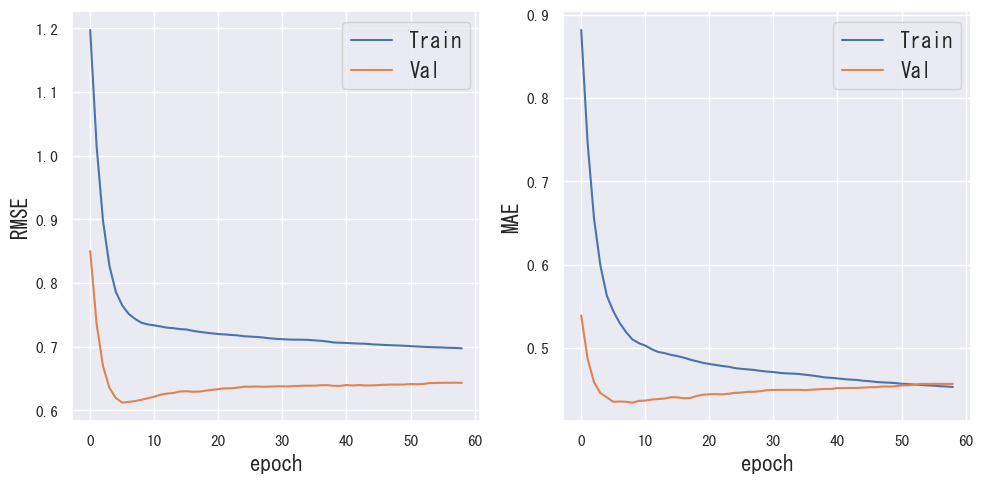

In [45]:
# Training metrics
results = xgb_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)

# Plot classification error
ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
ax2.plot(x_axis, results['validation_1']['mae'], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('MAE', fontsize=15)

plt.tight_layout()

In [46]:
xgb.plot_importance(xgb_reg)
plt.show()

In [47]:
pred = np.expand_dims(xgb_reg.predict(X_test), axis=1)

if norm_method == 'mean': # Mean normalization
    pred = pred * y_out + x_out 
    gt = y_test * y_out + x_out
elif norm_method == 'minmax': # Min Max normalization
    pred = pred * (y_out - x_out) + x_out
    gt = y_test * (y_out - x_out) + x_out

pred = reverse_transform(pred, transform_output)
gt = reverse_transform(gt, transform_output)

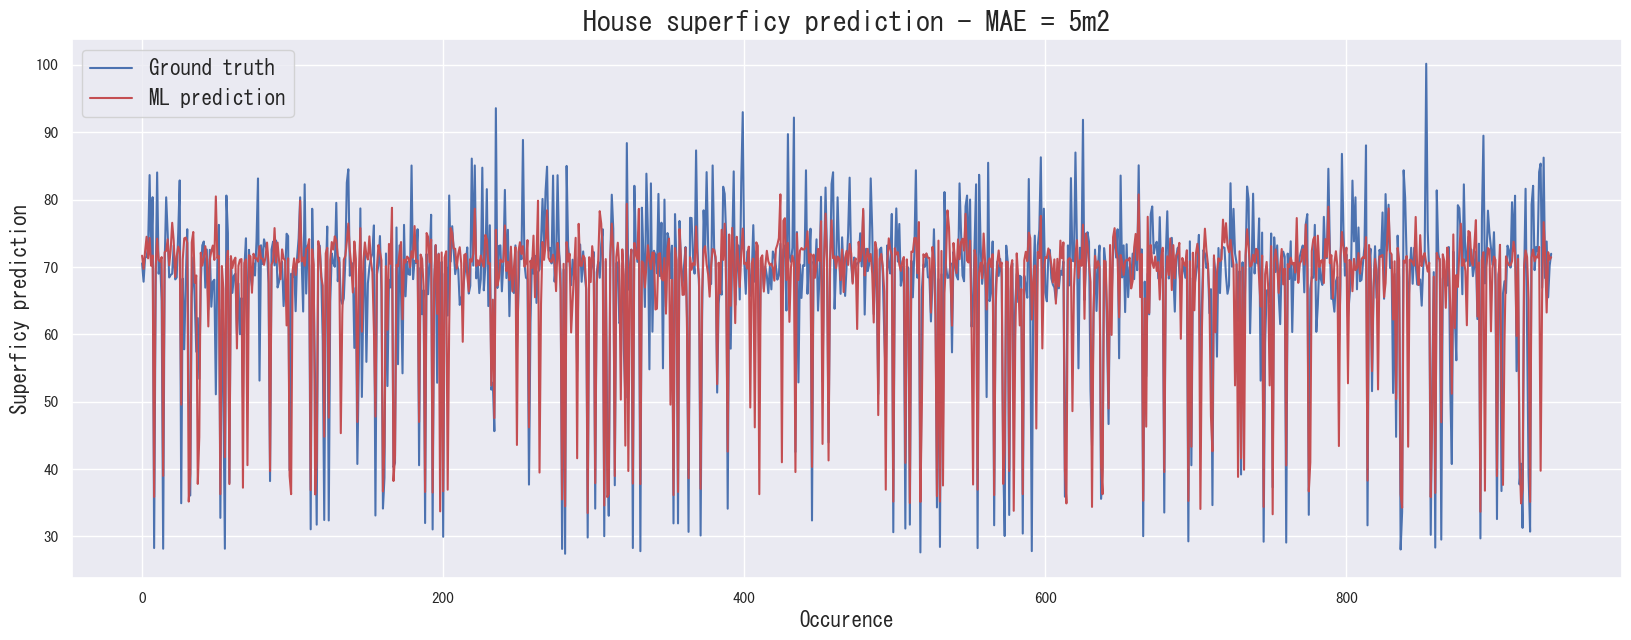

In [48]:
plt.figure(figsize=(20,7))
d = {'Ground truth': gt, 'Pred': pred}
res_pred = pd.DataFrame(data=d).reset_index()
mae = mean_absolute_error(gt, pred)

# # Plotting results
plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
plt.xlabel('Occurence', fontsize=15)
plt.ylabel('Superficy prediction', fontsize=15)
plt.title('House superficy prediction - MAE = %sm2'%(format(int(mae),',d')), fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [49]:
surface_range = [surface > pred[idx] - 1.0 * mae and surface <  pred[idx] + 1.0*mae for idx, surface in enumerate(gt)]
print(sum(surface_range)/len(surface_range))

0.6424759871931697


In [50]:
false_indices = [index for index, value in enumerate(surface_range) if value == False]
error_surface_index = X_test.index[false_indices]
verification_surface = data.loc[error_surface_index,:]
verification_surface['GT'] = gt.to_numpy()[false_indices]
verification_surface['prediction'] = pred[false_indices]
verification_surface = verification_surface.sort_values(by='GT', ascending=False)

verification_surface.head(15)

年齢\nage  合算後年収.1\nAnnual income after the sum .1  \
10220     37.0                                 6.000000   
11967     49.0                                11.500000   
12402     41.0                                20.000000   
8132      36.0                                 5.700000   
12480     48.0                                13.000000   
5799      53.0                                13.000000   
9697      39.0                                 4.920000   
9008      33.0                                 6.337739   
11201     40.0                                20.000000   
9671      37.0                                 9.000000   
12231     33.0                                10.240000   
9026      30.0                                 6.300000   
9942      41.0                                11.200000   
4624      38.0                                11.402619   
9908      44.0                                10.000000   

      合算後年収\nAnnual income after the sum  家族数\nFamily number 家族F\nFamily F  \
10220                                NaN                   3         パートナー   
11967                                NaN                   4      パートナーと子供   
12402                                NaN                   3      パートナーと子供   
8132                                 NaN                   3      パートナーと子供   
12480                                NaN                   4      パートナーと子供   
5799                                 NaN                   4      パートナーと子供   
9697                                 NaN                   4            独身   
9008                                 NaN                   4      パートナーと子供   
11201                                NaN                   5      パートナーと子供   
9671                                 NaN                   4            独身   
12231                                NaN                   5      パートナーと子供   
9026                                 NaN                   3      パートナーと子供   
9942                                 NaN                   3      パートナーと子供   
4624                                 NaN                   5      パートナーと子供   
9908                                 NaN                   4      パートナーと子供   

       物件価格(万円)\nProperty price (10,000 yen)  面積\narea      LP名\nLP name  \
10220                               4548.000    100.17            メイツ西白井   
11967                               6532.020     93.57          ソライエ新鎌ケ谷   
12402                               6998.000     92.98         メイツ船橋行田公園   
8132                                4478.000     92.18      リーフィアレジデンス橋本   
12480                               5806.605     91.85         ウエリス八千代村上   
5799                                4298.000     89.72         オハナ船橋習志野台   
9697                                4390.000     89.49        ミハマシティ検見川浜   
9008                                4289.000     88.86            オハナ西鎌倉   
11201                               5488.000     88.39  クレアホームズ王子神谷TOKYO   
9671                                4340.000     88.05        ミハマシティ検見川浜   
12231                               6898.000     87.30   調布ワンダーランドプロジェクト   
9026                                4298.000     86.99            オハナ西鎌倉   
9942                                4398.000     86.79          ルピアグランデ柏   
4624                                6340.000     86.28         プレミスト湘南辻堂   
9908                                4158.000     86.23       リビオシティ船橋高根台   

      最新住所\nLatest address  pref_code pref_name  city_code city_name  \
10220                  NaN       12.0       千葉県    12232.0       白井市   
11967                  NaN       12.0       千葉県    12224.0      鎌ケ谷市   
12402                  NaN       12.0       千葉県    12204.0       船橋市   
8132                   NaN       13.0       東京都    13209.0       町田市   
12480                  NaN       12.0       千葉県    12221.0      八千代市   
5799                   NaN       12.0       千葉県    12204.0       船橋市   
9697                   NaN       12.0       千葉県    12106.0    千葉市美浜区   
9008                